In [4]:
!pip install -q ultralytics torch torchvision --index-url https://download.pytorch.org/whl/cu121


In [5]:
from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, sys, os, json
import torch

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [6]:
project_root = Path.cwd()

def is_yolo_folder(p: Path) -> bool:
    if not (p / "data.yaml").exists():
        return False
    must = [
        p / "train" / "images",
        p / "train" / "labels",
        p / "valid" / "images",
        p / "valid" / "labels",
        p / "test"  / "images",
        p / "test"  / "labels",
    ]
    return all(x.exists() for x in must)

candidates = []
for p in project_root.iterdir():
    if p.is_dir() and p.name != ".venv":
        if is_yolo_folder(p):
            candidates.append(p)

# Prefer folder names that look like Roboflow exports
candidates_sorted = sorted(candidates, key=lambda x: ("yolov8" not in x.name.lower(), len(x.name)))

if not candidates_sorted:
    raise FileNotFoundError(
        "Could not find a YOLO dataset folder. Ensure your extracted dataset (with data.yaml, train/valid/test) "
        "is inside this project directory."
    )

dataset_dir = candidates_sorted[0]
print("✅ Using dataset folder:", dataset_dir)
print("Contains:", [x.name for x in dataset_dir.iterdir()])


✅ Using dataset folder: c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8
Contains: ['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


In [7]:
data_yaml_path = dataset_dir / "data.yaml"
with open(data_yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

# Ensure class names are a simple list in correct order (handle dict-to-list)
if isinstance(data_cfg.get("names"), dict):
    names = [data_cfg["names"][i] for i in range(len(data_cfg["names"]))]
else:
    names = list(data_cfg["names"])

# Build absolute paths
abs_train = str((dataset_dir / "train" / "images").resolve())
abs_val   = str((dataset_dir / "valid" / "images").resolve())
abs_test  = str((dataset_dir / "test"  / "images").resolve())

fixed_cfg = {
    "path": str(dataset_dir.resolve()),
    "train": abs_train,
    "val": abs_val,
    "test": abs_test,
    "names": names
}

with open(data_yaml_path, "w") as f:
    yaml.safe_dump(fixed_cfg, f, sort_keys=False)

print("✅ Rewrote data.yaml with absolute paths:")
print(json.dumps(fixed_cfg, indent=2))


✅ Rewrote data.yaml with absolute paths:
{
  "path": "C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\Yawn_detection.v2i.yolov8",
  "train": "C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\Yawn_detection.v2i.yolov8\\train\\images",
  "val": "C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\Yawn_detection.v2i.yolov8\\valid\\images",
  "test": "C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\Yawn_detection.v2i.yolov8\\test\\images",
  "names": [
    "no_yawn",
    "yawn"
  ]
}


In [8]:
model = YOLO("yolov8n.pt")   # yolov8s.pt for better accuracy (slower)

results = model.train(
    data=str(data_yaml_path),
    epochs=50,
    imgsz=640,
    batch=16,
    workers=0,        # Windows-friendly
    device=0 if torch.cuda.is_available() else "cpu"
)
results


New https://pypi.org/project/ultralytics/8.3.232 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, mom

KeyboardInterrupt: 

In [ ]:
val_results = model.val(data=str(data_yaml_path), device=0 if torch.cuda.is_available() else "cpu")
val_results


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1051.0307.2 MB/s, size: 38.2 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 11.3it/s 6.6s0.1s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 1.0ms preprocess, 2.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\2215

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F9777716F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [ ]:
val_images = list((dataset_dir / "valid" / "images").glob("*"))[:12]
if not val_images:
    print("No validation images found to preview.")
else:
    pred = model.predict(
        source=[str(p) for p in val_images],
        imgsz=640,
        conf=0.25,
        save=True,
        device=0 if torch.cuda.is_available() else "cpu"
    )
    pred



0: 640x640 3 yawns, 20.8ms
1: 640x640 3 yawns, 20.8ms
2: 640x640 2 yawns, 20.8ms
3: 640x640 1 yawn, 20.8ms
4: 640x640 3 yawns, 20.8ms
5: 640x640 2 yawns, 20.8ms
6: 640x640 3 yawns, 20.8ms
7: 640x640 2 yawns, 20.8ms
8: 640x640 3 yawns, 20.8ms
9: 640x640 3 yawns, 20.8ms
10: 640x640 1 yawn, 20.8ms
11: 640x640 2 yawns, 20.8ms
Speed: 3.8ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\runs\detect\predict


In [ ]:
exported = model.export(format="onnx")  # options: onnx, openvino, torchscript, coreml, tflite, engine
exported


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900HX)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\runs\detect\train2\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.5 MB 2.8 MB/s eta 0:00:06
   --- ------------------------------------ 1.3/16.5 MB 2.8 MB/s eta 0:00:06
   ----- ---------------------------------- 2.1/16.5 MB 2.9 MB/s eta 0:00:05
   ------- -------------------------------- 2.9/16.5 MB 3.2 MB

'C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\runs\\detect\\train2\\weights\\best.onnx'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")


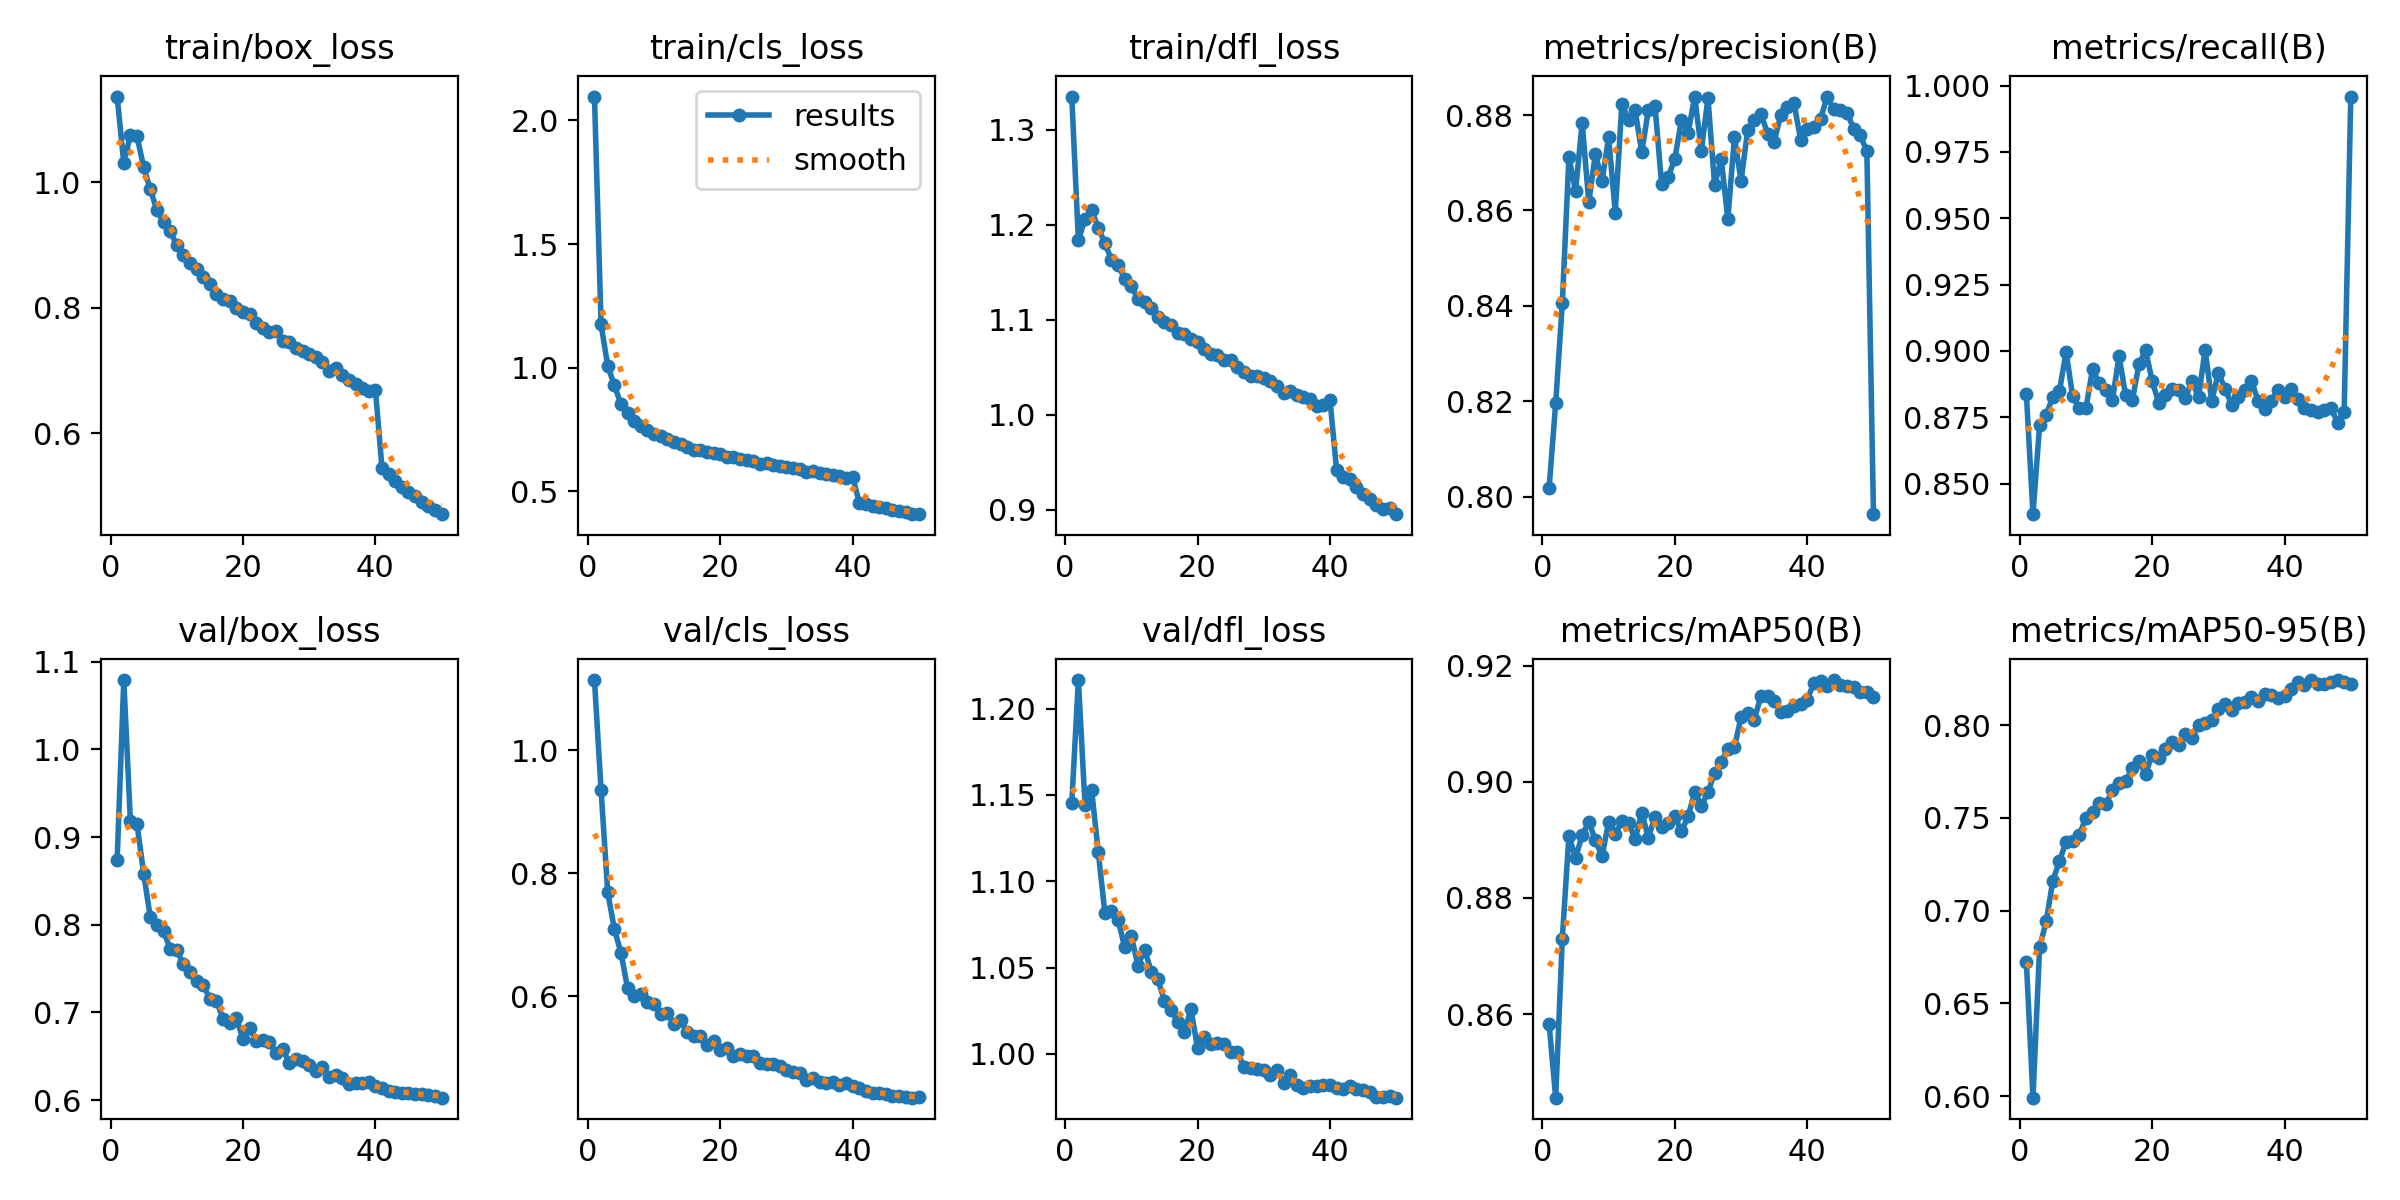

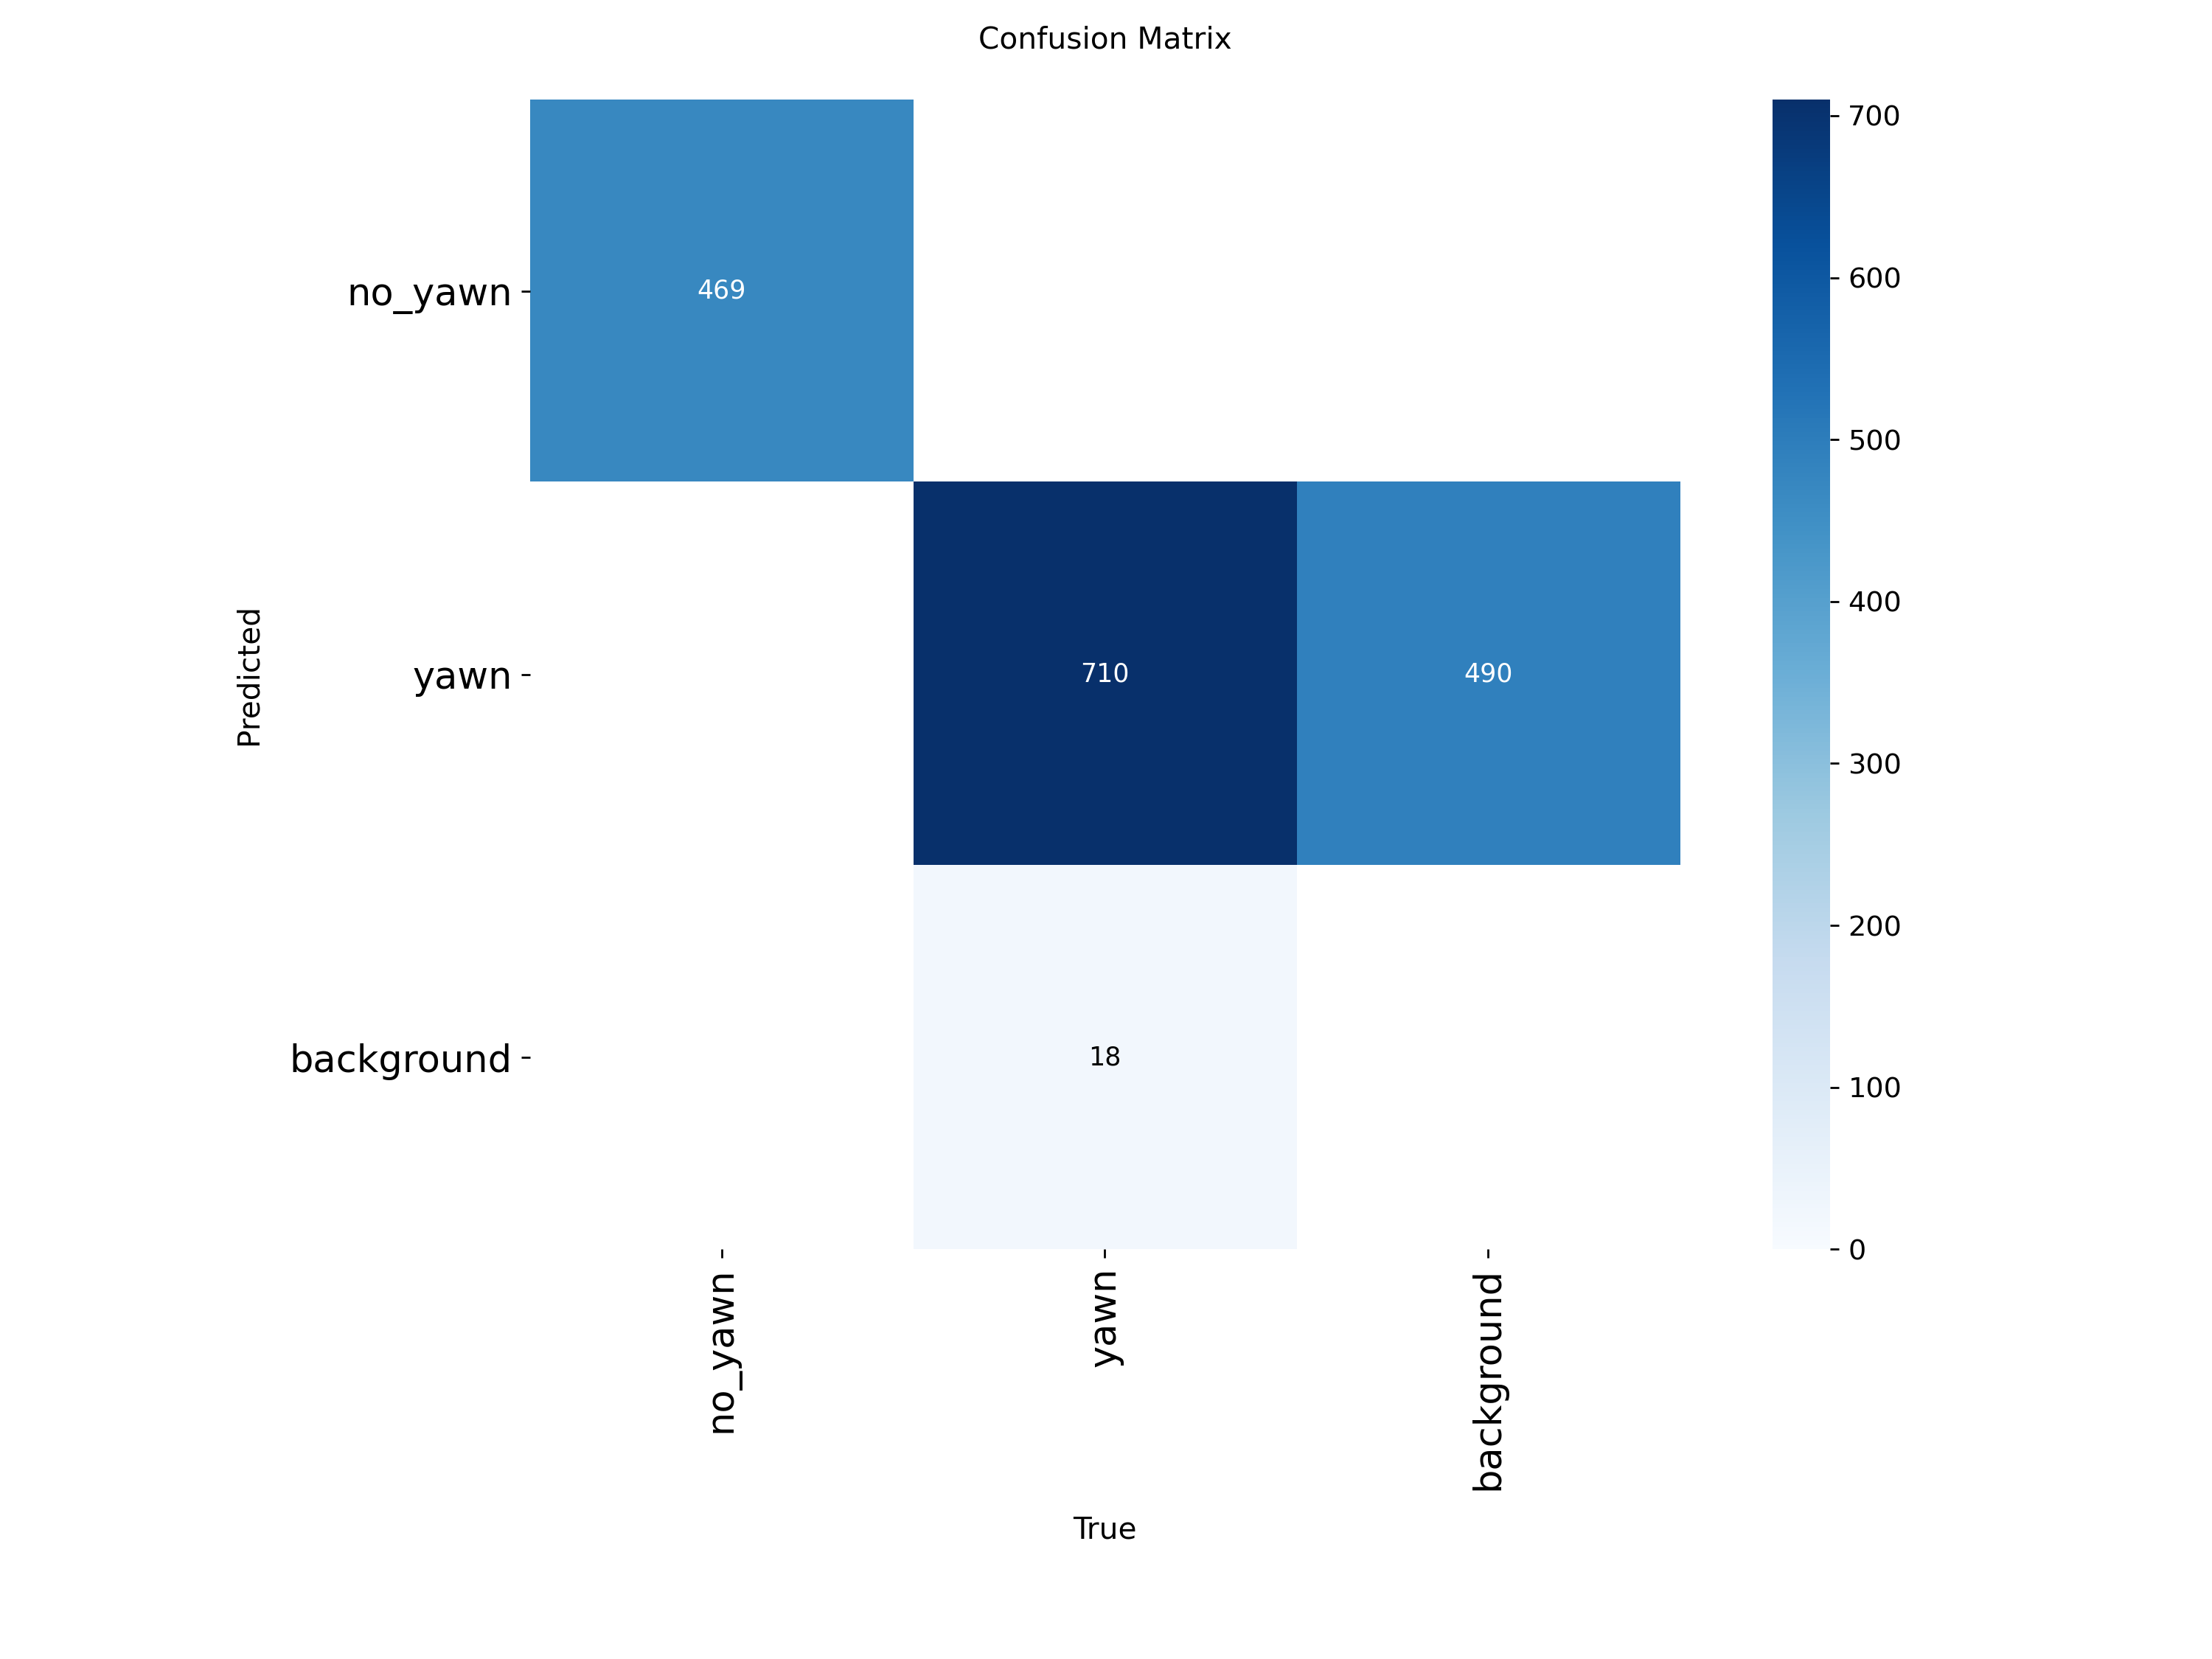

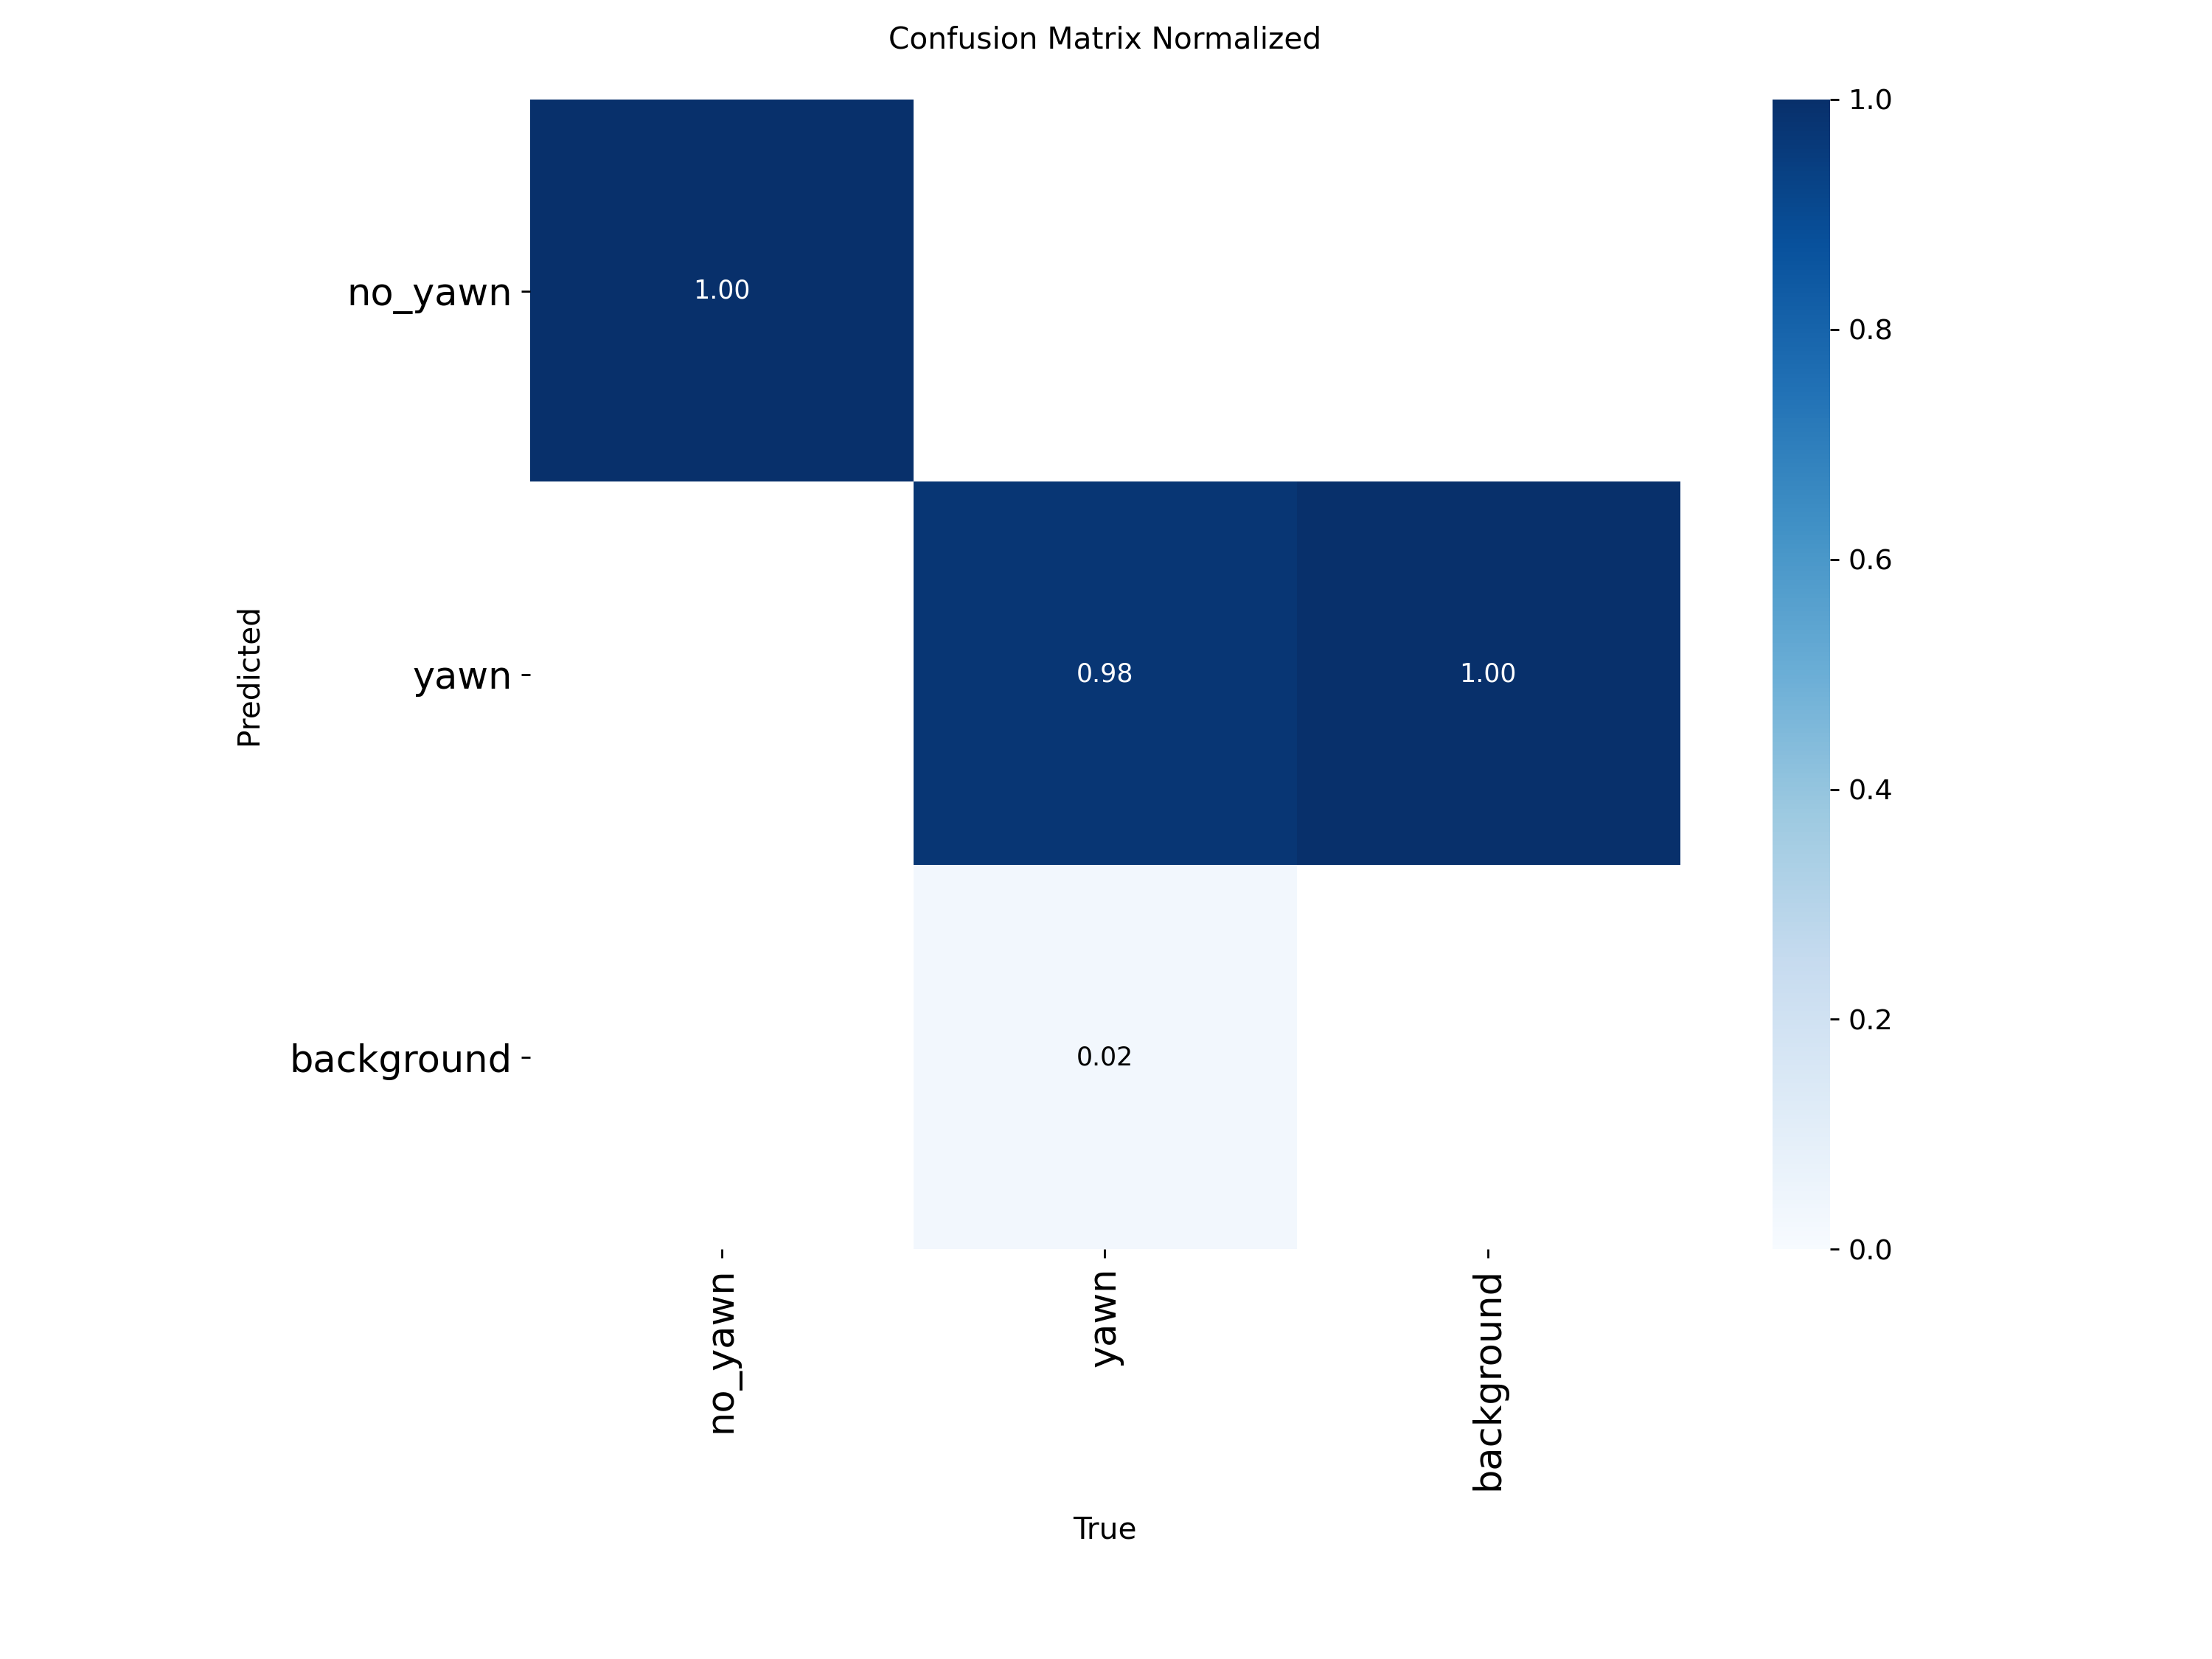

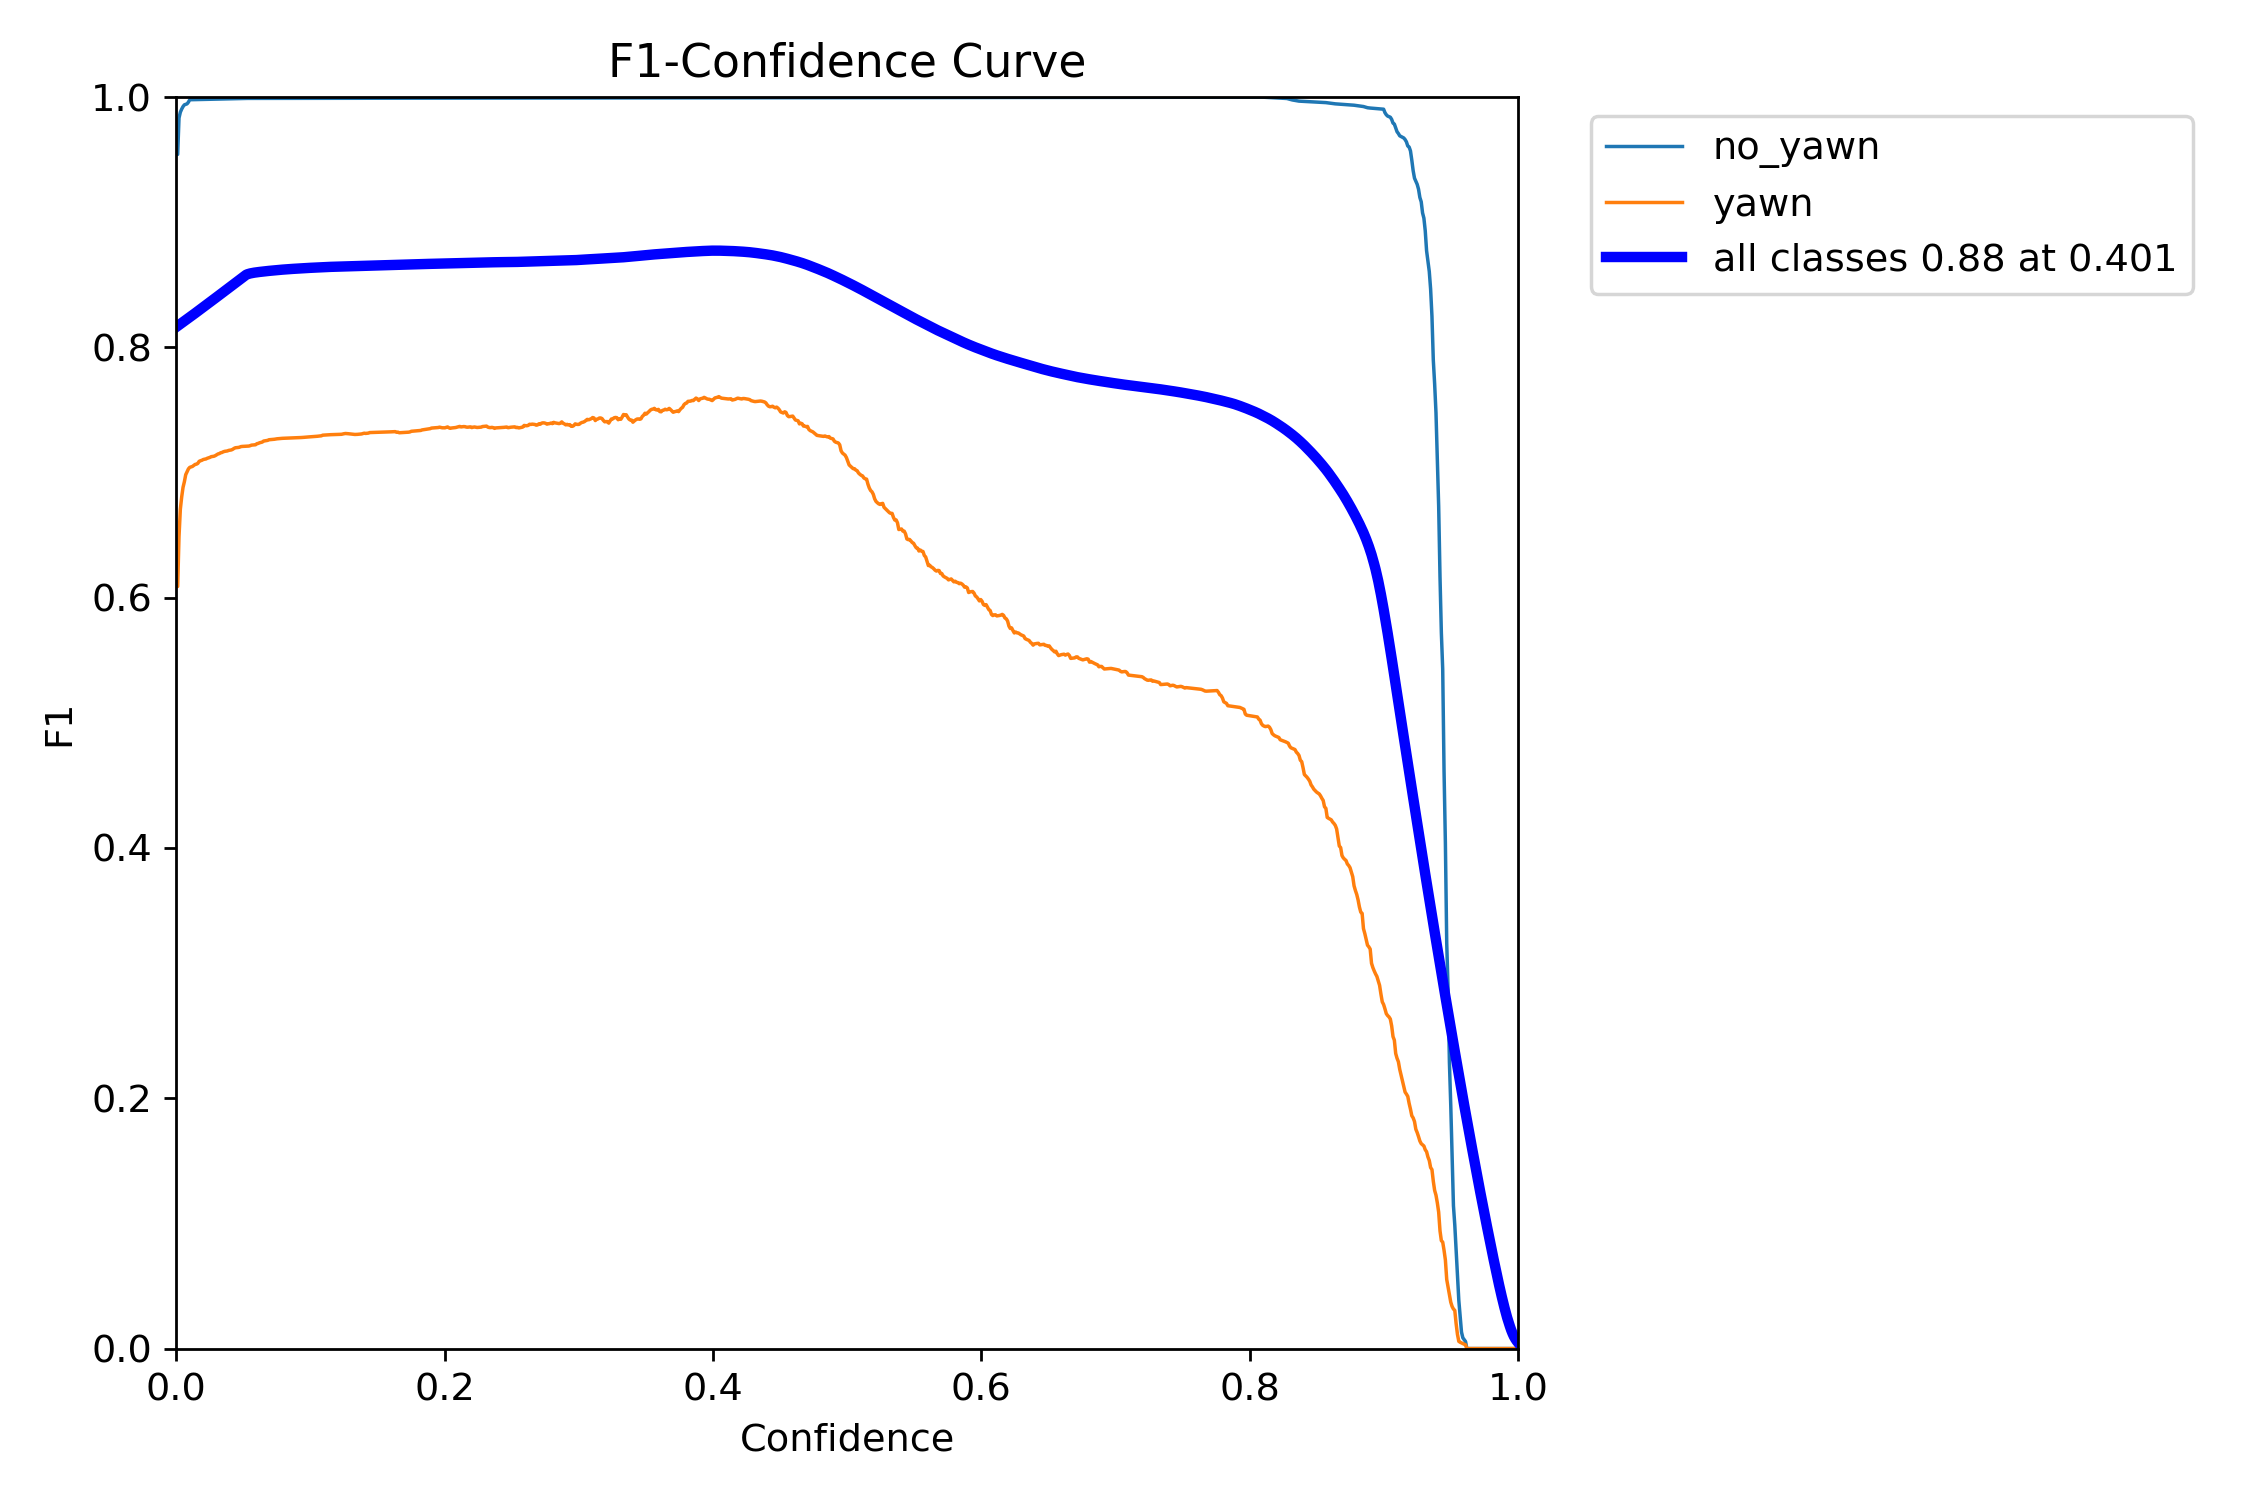

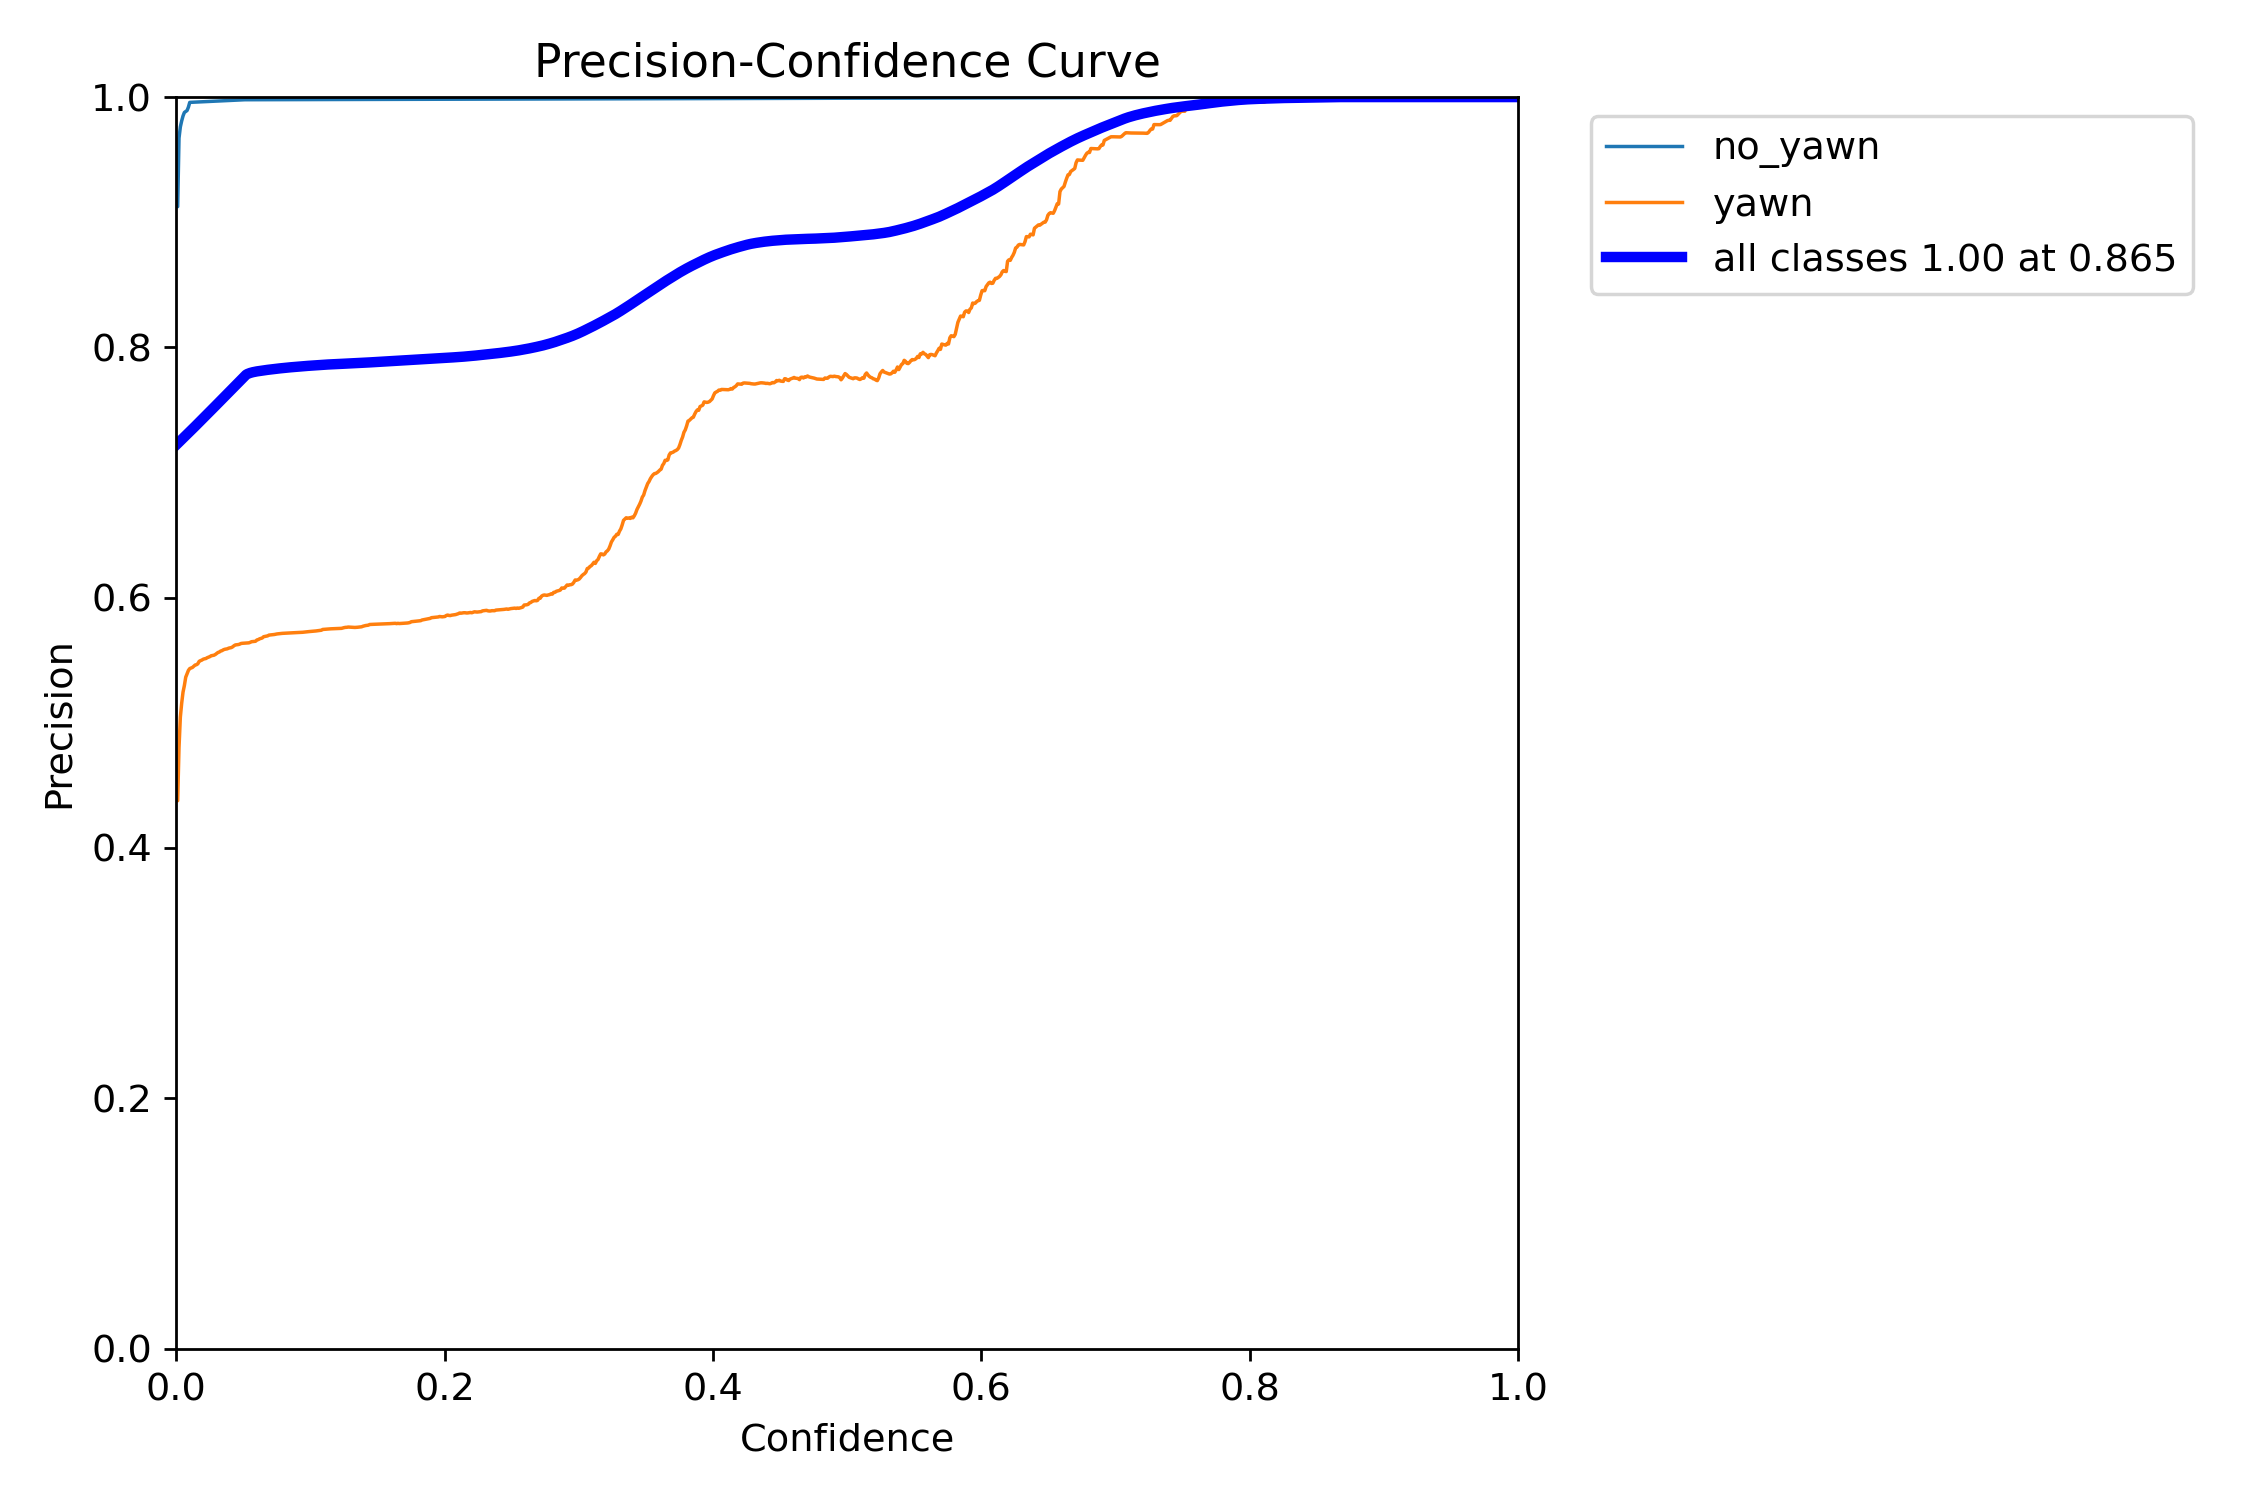

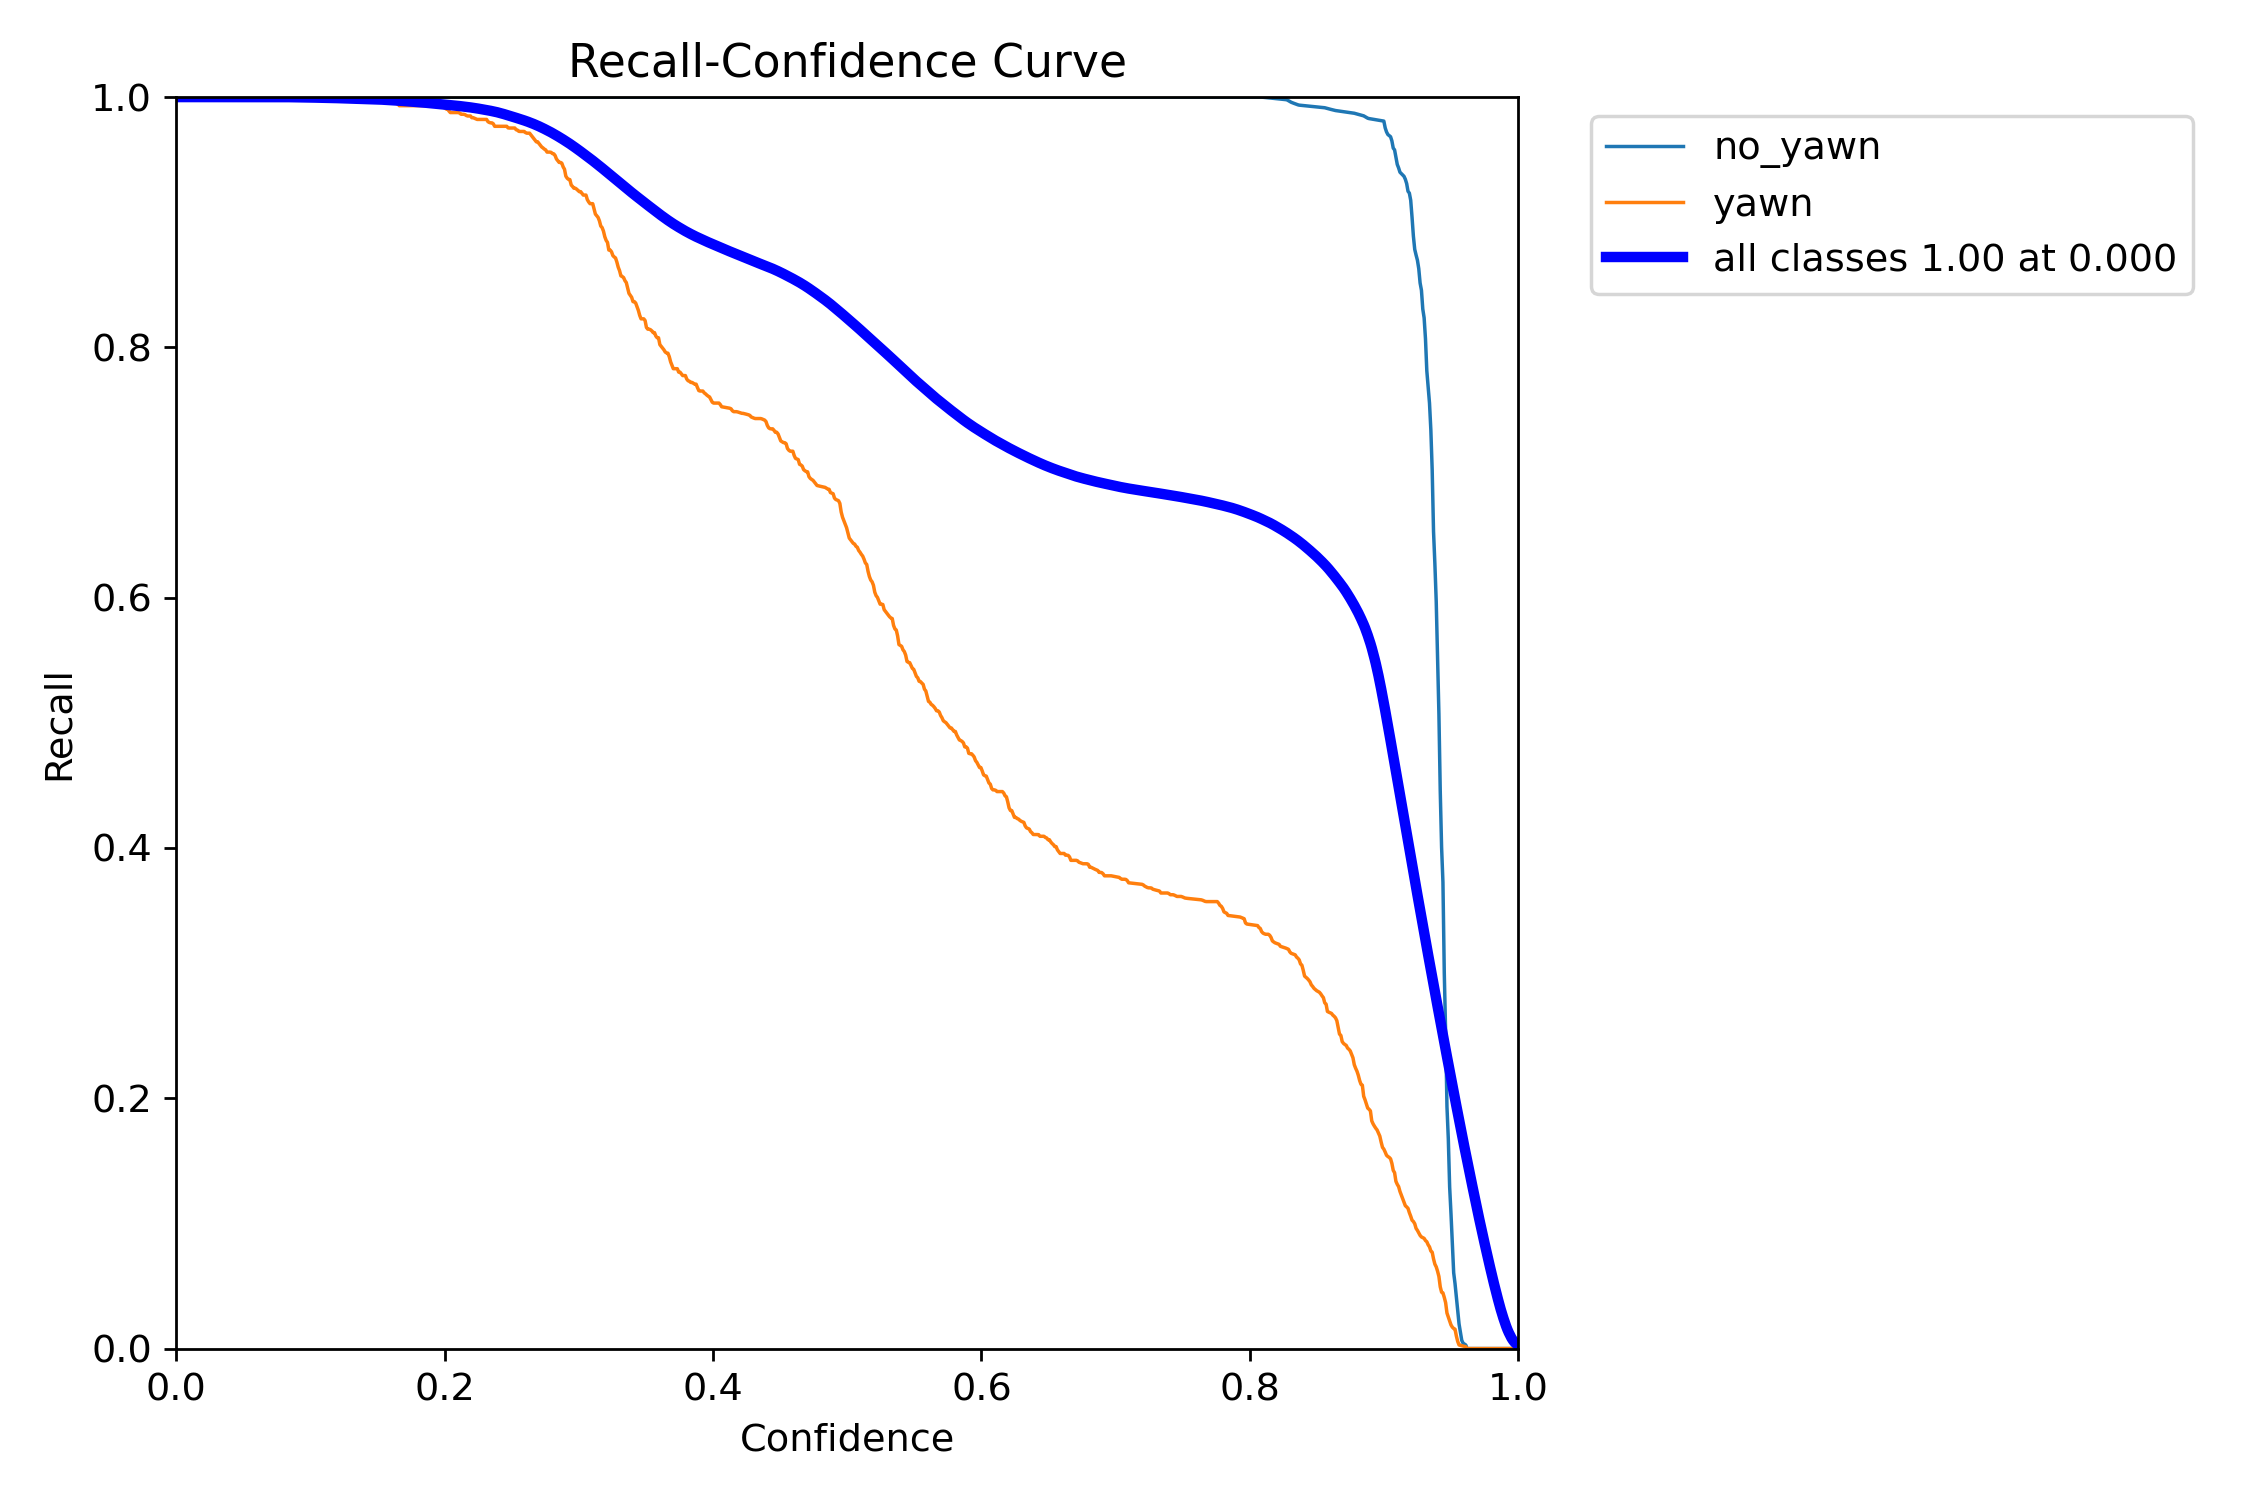

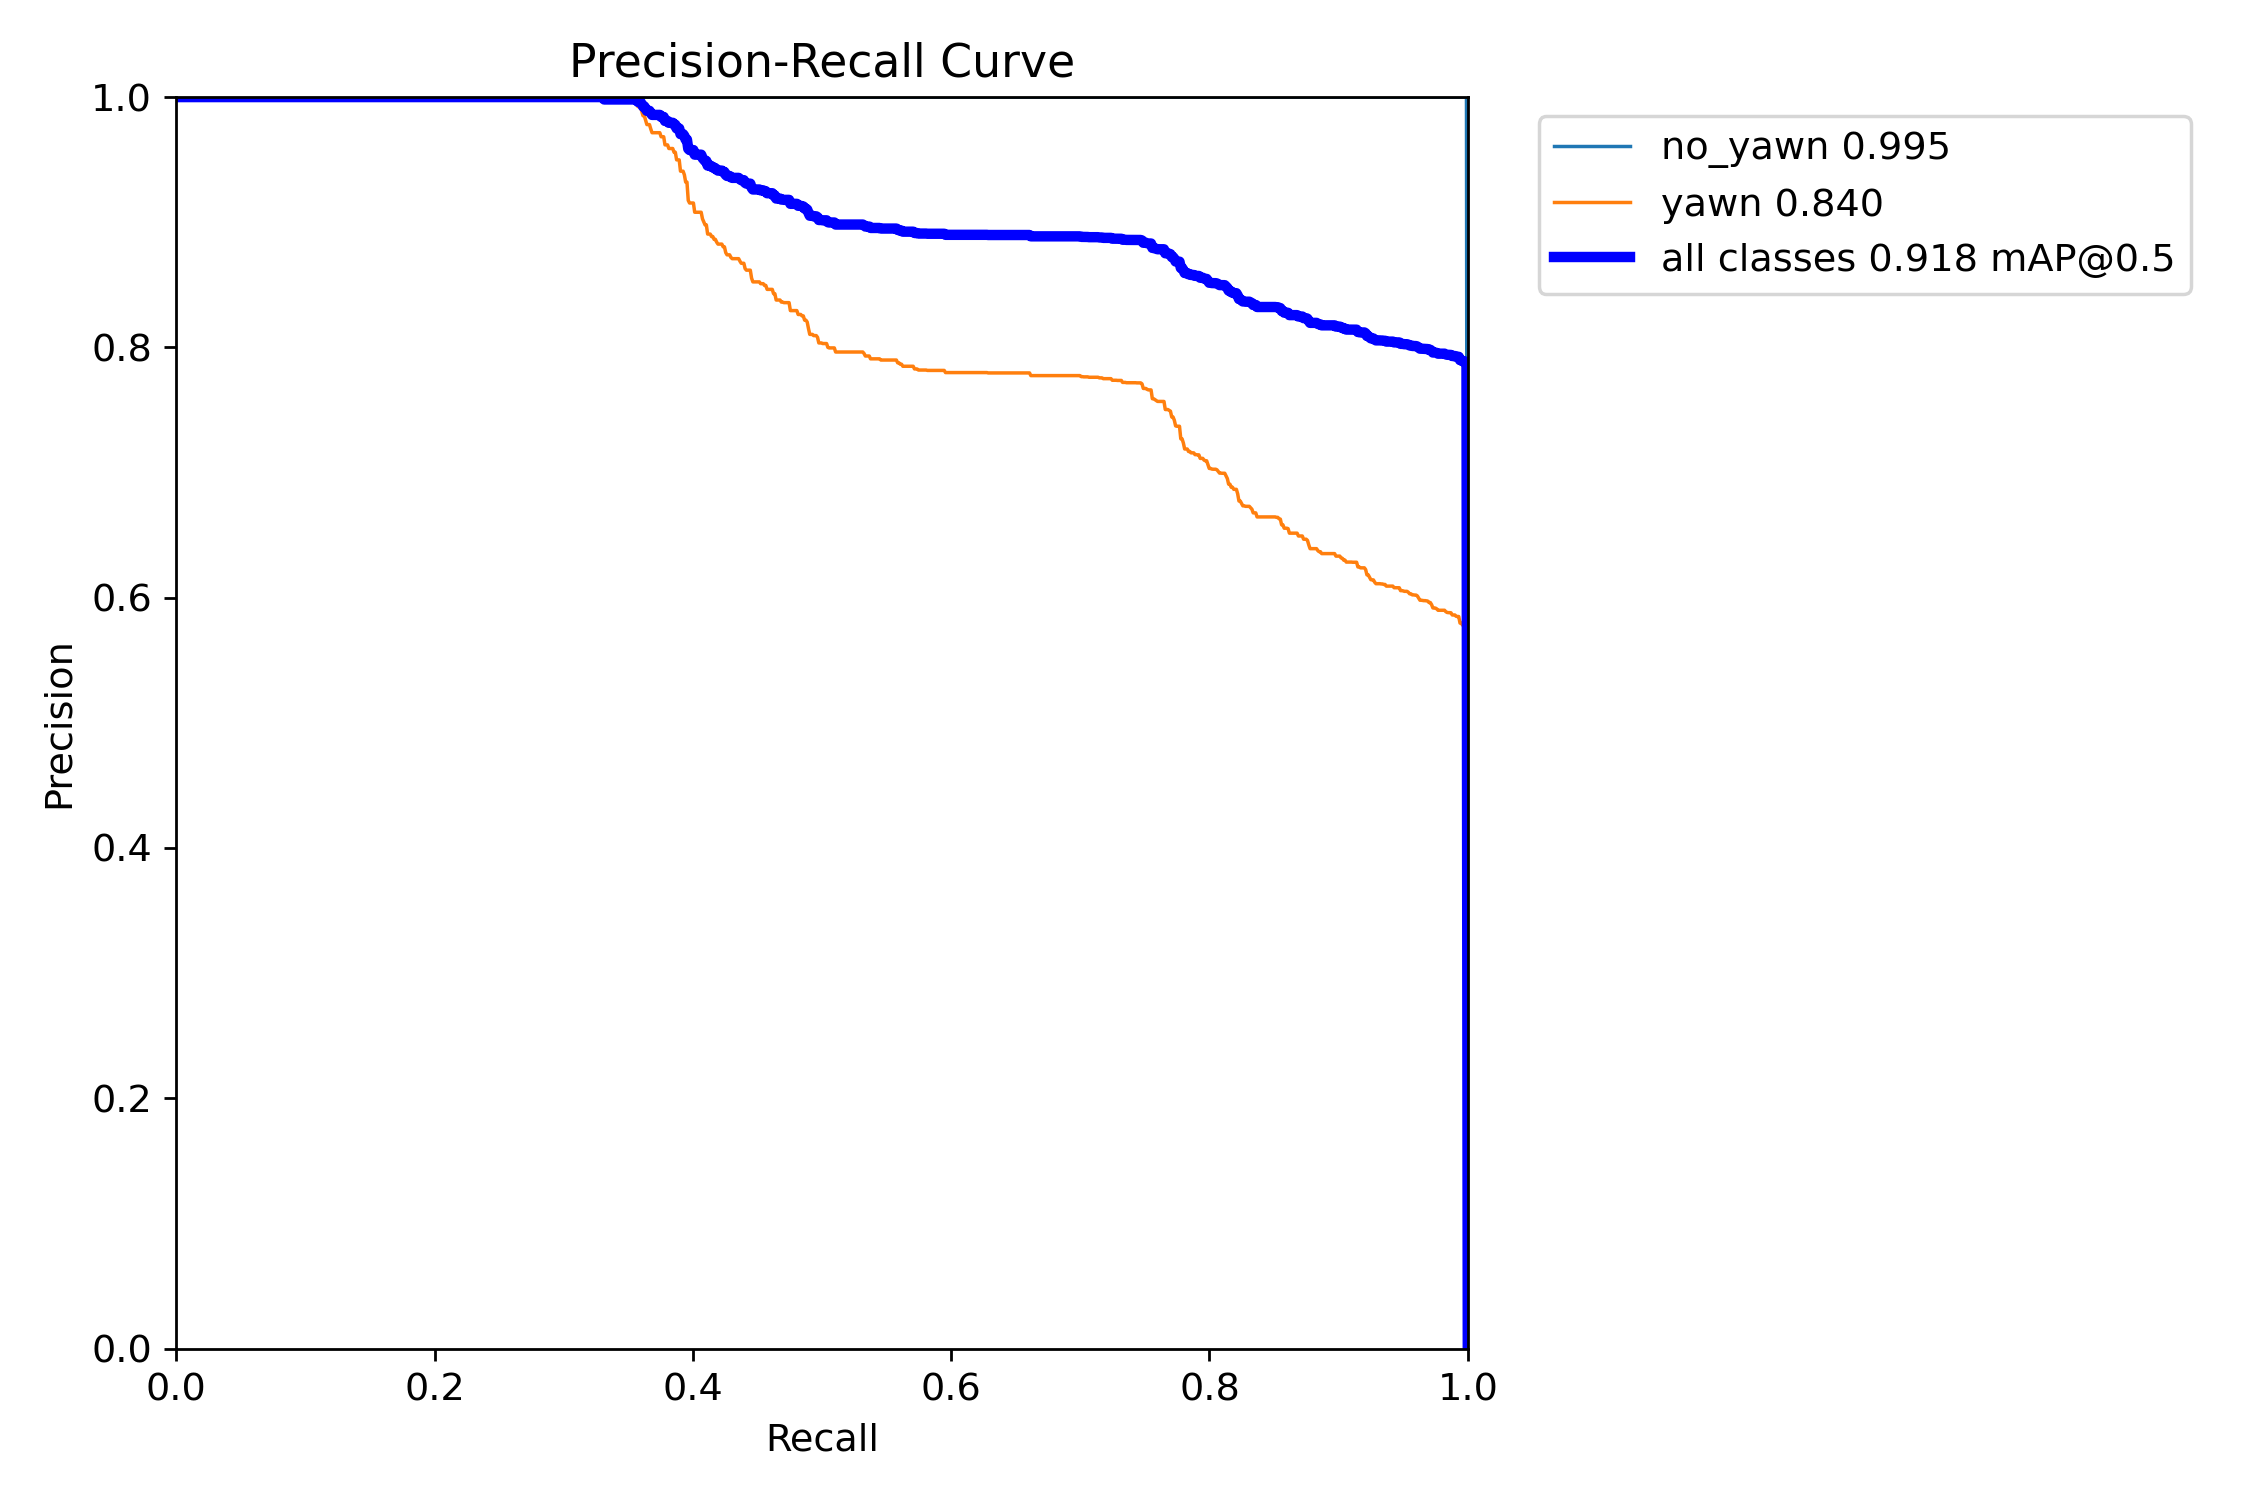

In [ ]:
result_path = "runs/detect/train2"

images = [
    "results.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "BoxPR_curve.png",
]

for img in images:
    p = os.path.join(result_path, img)
    if os.path.exists(p):
        display(Image.open(p))
    else:
        print("Not found:", img)


In [ ]:
df = pd.read_csv("runs/detect/train2/results.csv")
df.head()
print(list(df.columns))


['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


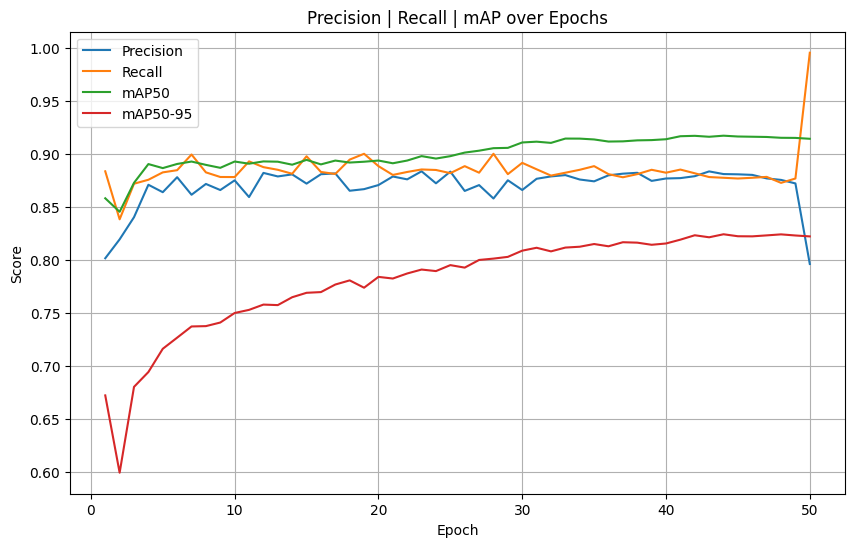

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label="Precision")
plt.plot(df['epoch'], df['metrics/recall(B)'], label="Recall")
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label="mAP50")
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label="mAP50-95")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision | Recall | mAP over Epochs")
plt.legend()
plt.grid()
plt.show()


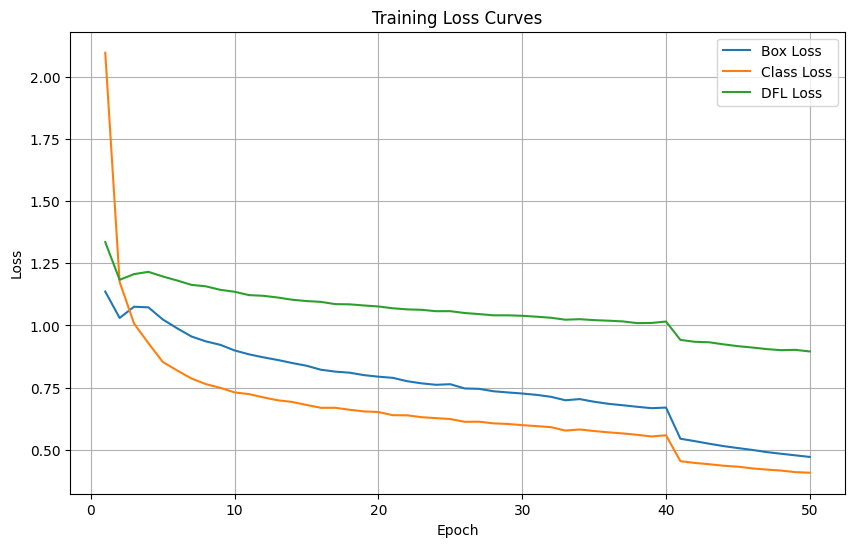

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label="Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Class Loss")
plt.plot(df['epoch'], df['train/dfl_loss'], label="DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid()
plt.show()


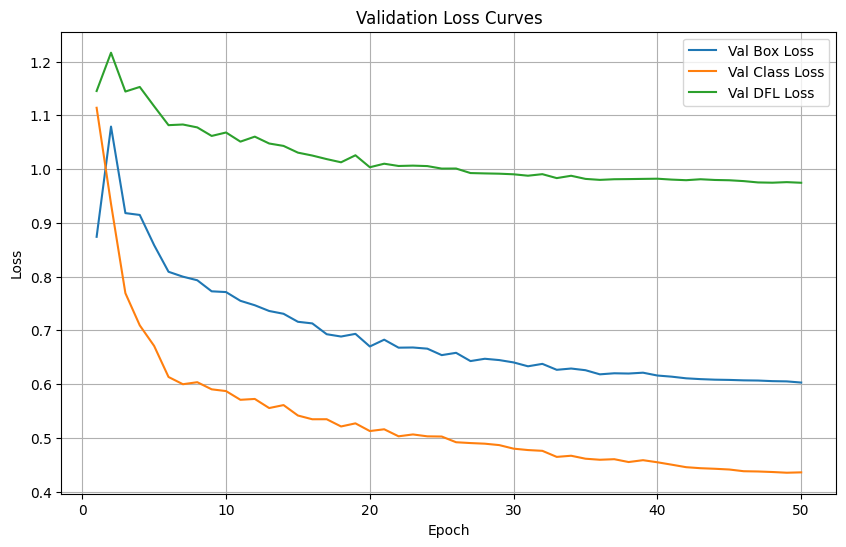

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['val/box_loss'], label="Val Box Loss")
plt.plot(df['epoch'], df['val/cls_loss'], label="Val Class Loss")
plt.plot(df['epoch'], df['val/dfl_loss'], label="Val DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.grid()
plt.show()


Predicting on: 126_jpg.rf.d3e8c814e3b9e260117a7daaa2bc82b6.jpg

image 1/1 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\126_jpg.rf.d3e8c814e3b9e260117a7daaa2bc82b6.jpg: 640x640 2 yawns, 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\runs\detect\predict2
Showing result from: runs/detect\predict2


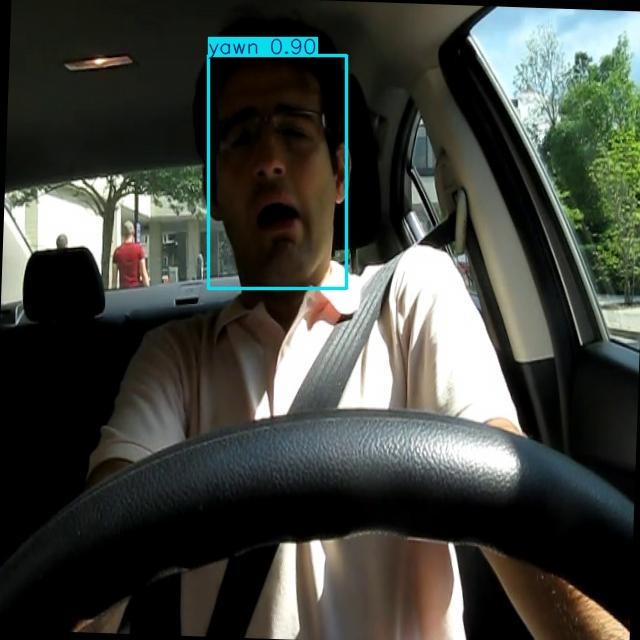

In [ ]:
import os
import random

# Path to test images
test_path = "Yawn_detection.v2i.yolov8/test/images"

# Pick random image
files = [f for f in os.listdir(test_path) if f.lower().endswith((".jpg", ".png"))]
random_image = random.choice(files)

image_path = os.path.join(test_path, random_image)
print("Predicting on:", random_image)

# Run YOLO prediction
results = model.predict(image_path, save=True)

# ✅ Find the latest prediction folder
base_dir = "runs/detect"
folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.startswith("predict")]
latest_pred_folder = max(folders, key=os.path.getctime)

print("Showing result from:", latest_pred_folder)

# ✅ Find the single predicted file inside folder
pred_files = [f for f in os.listdir(latest_pred_folder) if f.lower().endswith((".jpg", ".png"))]

if len(pred_files) == 0:
    print("No prediction image found!")
else:
    pred_path = os.path.join(latest_pred_folder, pred_files[0])
    display(Image.open(pred_path))


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")

metrics = model.val(data="Yawn_detection.v2i.yolov8/data.yaml")
metrics


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 169.368.5 MB/s, size: 45.1 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 4.7it/s 15.9s0.2s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 2.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\221501

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F96C933670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")
metrics = model.val(data="Yawn_detection.v2i.yolov8/data.yaml")


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1092.1269.0 MB/s, size: 40.1 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 6.4it/s 11.7s<0.1s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 1.6ms preprocess, 2.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\221

In [ ]:
model = YOLO("runs/detect/train2/weights/best.pt")
metrics = model.val()
metrics.box.map       # mAP50-95 overall
metrics.box.map50     # mAP50
metrics.box.map75     # mAP75
metrics.box.maps      # mAP for each class


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1255.0363.3 MB/s, size: 44.1 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 10.8it/s 6.9s0.1s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 1.0ms preprocess, 2.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\221501149\ya

array([    0.96257,     0.68696])

In [ ]:
test_path = "Yawn_detection.v2i.yolov8/test/images"

test_results = model.predict(source=test_path, save=False)

print("Total Test Images:", len(test_results))



image 1/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\100_jpg.rf.20c6e525a9aa9e42db7915e11a688d01.jpg: 640x640 1 yawn, 17.6ms
image 2/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\103_jpg.rf.53fd65960533cf63f234d7b4fde4b805.jpg: 640x640 3 yawns, 17.9ms
image 3/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\104_jpg.rf.269df32caf7eea96e4a06083fb5b9b25.jpg: 640x640 1 yawn, 17.9ms
image 4/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\105_jpg.rf.a3045fa0e3c938f41d9995c540bfd1ba.jpg: 640x640 3 yawns, 19.4ms
image 5/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\106_jpg.rf.9cb9d612e607df54b77aaf3cd6341c55.jpg: 640x640 3 yawns, 17.8ms
image 6/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.y

In [ ]:
pip install scikit-learn


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.9 MB 2.8 MB/s eta 0:00:03
   -------- ------------------------------- 1.8/8.9 MB 3.2 MB/s eta 0:00:03
   ----------- ---------------------------- 2.6/8.9 MB 3.4 MB/s eta 0:00:02
   ----------------- ---------------------- 3.9/8.9 MB 4.0 MB/s eta 0:00:02
   ------------------------ --------------- 5.5/8.9 MB 4.7 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.9 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 5.8 MB/s  0:00:01

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -----

In [ ]:
from sklearn.metrics import accuracy_score
import os

test_img_path = "Yawn_detection.v2i.yolov8/test/images"
test_label_path = "Yawn_detection.v2i.yolov8/test/labels"

y_true = []
y_pred = []

# Run YOLO prediction on entire test set
results = model.predict(test_img_path, save=False)

for r in results:
    img_name = os.path.basename(r.path)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(test_label_path, label_name)

    # ✅ Read ground truth label
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            cls_true = int(f.read().split()[0])
            y_true.append(cls_true)
    else:
        continue

    # ✅ Predicted class (highest confidence)
    if len(r.boxes.cls) > 0:
        cls_pred = int(r.boxes.cls[0])
    else:
        cls_pred = -1  # no detection

    y_pred.append(cls_pred)

# ✅ Calculate true accuracy
accuracy = accuracy_score(y_true, y_pred)

print("✅ REAL Test Set Accuracy:", round(accuracy*100, 2), "%")
print(f"Correct Predictions: {sum([a==b for a,b in zip(y_true,y_pred)])}/{len(y_true)}")



image 1/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\100_jpg.rf.20c6e525a9aa9e42db7915e11a688d01.jpg: 640x640 1 yawn, 17.7ms
image 2/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\103_jpg.rf.53fd65960533cf63f234d7b4fde4b805.jpg: 640x640 3 yawns, 18.0ms
image 3/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\104_jpg.rf.269df32caf7eea96e4a06083fb5b9b25.jpg: 640x640 1 yawn, 17.8ms
image 4/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\105_jpg.rf.a3045fa0e3c938f41d9995c540bfd1ba.jpg: 640x640 3 yawns, 18.0ms
image 5/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\106_jpg.rf.9cb9d612e607df54b77aaf3cd6341c55.jpg: 640x640 3 yawns, 17.9ms
image 6/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.y


image 1/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\100_jpg.rf.20c6e525a9aa9e42db7915e11a688d01.jpg: 640x640 1 yawn, 17.7ms
image 2/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\103_jpg.rf.53fd65960533cf63f234d7b4fde4b805.jpg: 640x640 3 yawns, 17.9ms
image 3/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\104_jpg.rf.269df32caf7eea96e4a06083fb5b9b25.jpg: 640x640 1 yawn, 17.9ms
image 4/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\105_jpg.rf.a3045fa0e3c938f41d9995c540bfd1ba.jpg: 640x640 3 yawns, 17.9ms
image 5/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\106_jpg.rf.9cb9d612e607df54b77aaf3cd6341c55.jpg: 640x640 3 yawns, 17.9ms
image 6/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.y

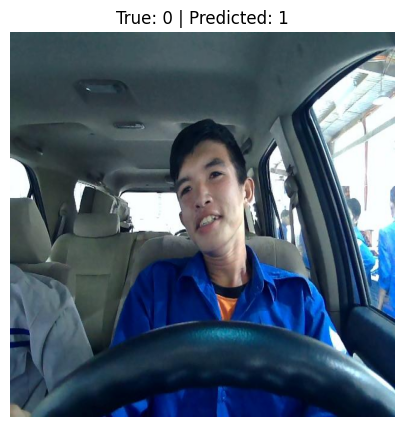

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

test_img_path = "Yawn_detection.v2i.yolov8/test/images"
test_label_path = "Yawn_detection.v2i.yolov8/test/labels"

misclassified = []

# Run YOLO prediction on test set again
results = model.predict(test_img_path, save=False)

for r in results:
    img_name = os.path.basename(r.path)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(test_label_path, label_name)

    # ✅ True label
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            cls_true = int(f.read().split()[0])
    else:
        continue

    # ✅ Predicted label
    if len(r.boxes.cls) > 0:
        cls_pred = int(r.boxes.cls[0])
    else:
        cls_pred = -1

    # ✅ Save misclassified
    if cls_true != cls_pred:
        misclassified.append((img_name, cls_true, cls_pred))

# ✅ Display result
print("Total Misclassified:", len(misclassified))

if len(misclassified) > 0:
    img_name, true_label, pred_label = misclassified[0]
    img_path = os.path.join(test_img_path, img_name)

    print(f"\n❌ Misclassified Image: {img_name}")
    print(f"✅ True Label      : {true_label}")
    print(f"❌ Predicted Label : {pred_label}")

    # show image
    img = Image.open(img_path)
    plt.figure(figsize=(6,5))
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {pred_label}")
    plt.axis("off")
    plt.show()
else:
    print("✅ No misclassified images found!")


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")

# ✅ Print full model summary
model.info(verbose=True)


Model summary: 129 layers, 3,011,238 parameters, 0 gradients, 8.2 GFLOPs


(129, 3011238, 0, 8.1952256)

In [ ]:
summary = model.info(detailed=False)
summary


Model summary: 129 layers, 3,011,238 parameters, 0 gradients, 8.2 GFLOPs


(129, 3011238, 0, 8.1952256)

In [ ]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ultralytics import YOLO
import torch

model = YOLO("runs/detect/train2/weights/best.pt")
net = model.model

total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("Total Parameters     :", total_params)
print("Trainable Parameters :", trainable_params)
print("Model Size (MB)      :", total_params * 4 / (1024 * 1024))


Total Parameters     : 3011238
Trainable Parameters : 0
Model Size (MB)      : 11.486961364746094


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")
print(model.model)


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [ ]:
pip install thop



  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
    Uninstalling sympy-1.14.0:
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]



ERROR: Could not install packages due to an OSError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Sudharsaa\\Documents\\221501149\\yawn-detection-yolo\\.venv\\Lib\\site-packages\\~ympy'



In [ ]:
from ultralytics import YOLO
from thop import profile
import torch

model = YOLO("runs/detect/train2/weights/best.pt").model
dummy = torch.randn(1, 3, 640, 640)

flops, params = profile(model, inputs=(dummy, ))

print("FLOPs:", flops / 1e9, "GFLOPs")
print("Params:", params)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 4.0976128 GFLOPs
Params: 3011238.0


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")
model.export(format="onnx")


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900HX)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train2\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  0.8s, saved as 'runs\detect\train2\weights\best.onnx' (11.7 MB)

Export complete (1.0s)
Results saved to C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\runs\detect\train2\weights
Predict:         yolo predict task=detect model=runs\detect\train2\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train2\weights\best.onnx imgsz=640 data=c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\data.yaml  
Visualize:       https://netron.app


'runs\\detect\\train2\\weights\\best.onnx'

   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.2 MB 1.9 MB/s eta 0:00:04
   ------ --------------------------------- 1.0/6.2 MB 2.1 MB/s eta 0:00:03
   ----------- ---------------------------- 1.8/6.2 MB 2.6 MB/s eta 0:00:02
   ------------------ --------------------- 2.9/6.2 MB 3.0 MB/s eta 0:00:02
   ----------------------- ---------------- 3.7/6.2 MB 3.3 MB/s eta 0:00:01
   ------------------------------ --------- 4.7/6.2 MB 3.5 MB/s eta 0:00:01
   ------------------------------------- -- 5.8/6.2 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 3.8 MB/s  0:00:01

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxslim 0.1.74 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.


In [ ]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchinfo import summary
from ultralytics import YOLO
import torch

model = YOLO("runs/detect/train2/weights/best.pt")
net = model.model

device = "cuda" if torch.cuda.is_available() else "cpu"
net = net.to(device)

summary(net, input_size=(1, 3, 640, 640))


Layer (type:depth-idx)                             Output Shape              Param #
DetectionModel                                     [1, 6, 8400]              --
├─Sequential: 1-1                                  --                        --
│    └─Conv: 2-1                                   [1, 16, 320, 320]         --
│    │    └─Conv2d: 3-1                            [1, 16, 320, 320]         (432)
│    │    └─BatchNorm2d: 3-2                       [1, 16, 320, 320]         (32)
│    └─Detect: 2-96                                --                        (recursive)
│    │    └─ModuleList: 3-118                      --                        (recursive)
│    └─Conv: 2-3                                   [1, 32, 160, 160]         --
│    │    └─Conv2d: 3-4                            [1, 32, 160, 160]         (4,608)
│    │    └─BatchNorm2d: 3-5                       [1, 32, 160, 160]         (64)
│    └─Detect: 2-96                                --                        (recursi

In [ ]:
from ultralytics import YOLO
import os
from sklearn.metrics import accuracy_score

# Load model
model = YOLO("runs/detect/train2/weights/best.pt")

# Paths
test_img_path   = "Yawn_detection.v2i.yolov8/test/images"
test_label_path = "Yawn_detection.v2i.yolov8/test/labels"

y_true = []
y_pred = []

# Run prediction on test set
results = model.predict(test_img_path, save=False)

for r in results:
    img_name = os.path.basename(r.path)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(test_label_path, label_name)

    # ✅ Ground truth
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            cls_true = int(f.read().split()[0])
            y_true.append(cls_true)
    else:
        continue

    # ✅ Predicted label
    if len(r.boxes.cls) > 0:
        cls_pred = int(r.boxes.cls[0])
    else:
        cls_pred = -1  # no detection

    y_pred.append(cls_pred)

# ✅ Accuracy
accuracy = accuracy_score(y_true, y_pred)

# ✅ Nicely formatted print
correct = sum([a == b for a, b in zip(y_true, y_pred)])
total   = len(y_true)

print("=====================================")
print("✅ YOLOv8 Model Test Accuracy")
print("=====================================")
print(f"Accuracy           : {accuracy * 100:.2f}%")
print(f"Correct Predictions: {correct}/{total}")
print("=====================================")



image 1/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\100_jpg.rf.20c6e525a9aa9e42db7915e11a688d01.jpg: 640x640 1 yawn, 17.7ms
image 2/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\103_jpg.rf.53fd65960533cf63f234d7b4fde4b805.jpg: 640x640 3 yawns, 17.6ms
image 3/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\104_jpg.rf.269df32caf7eea96e4a06083fb5b9b25.jpg: 640x640 1 yawn, 18.1ms
image 4/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\105_jpg.rf.a3045fa0e3c938f41d9995c540bfd1ba.jpg: 640x640 3 yawns, 16.1ms
image 5/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\106_jpg.rf.9cb9d612e607df54b77aaf3cd6341c55.jpg: 640x640 3 yawns, 16.3ms
image 6/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.y

In [ ]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



image 1/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\100_jpg.rf.20c6e525a9aa9e42db7915e11a688d01.jpg: 640x640 1 yawn, 17.6ms
image 2/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\103_jpg.rf.53fd65960533cf63f234d7b4fde4b805.jpg: 640x640 3 yawns, 17.6ms
image 3/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\104_jpg.rf.269df32caf7eea96e4a06083fb5b9b25.jpg: 640x640 1 yawn, 17.8ms
image 4/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\105_jpg.rf.a3045fa0e3c938f41d9995c540bfd1ba.jpg: 640x640 3 yawns, 17.6ms
image 5/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\images\106_jpg.rf.9cb9d612e607df54b77aaf3cd6341c55.jpg: 640x640 3 yawns, 14.5ms
image 6/628 c:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.y

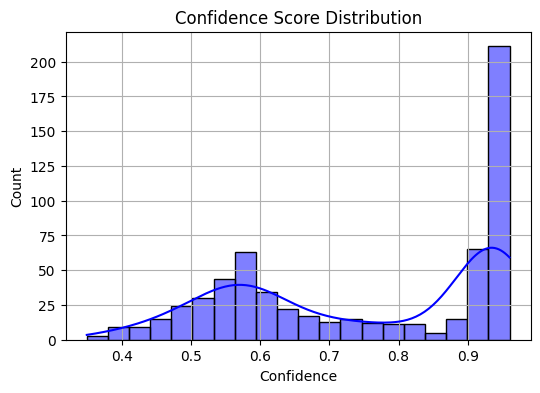

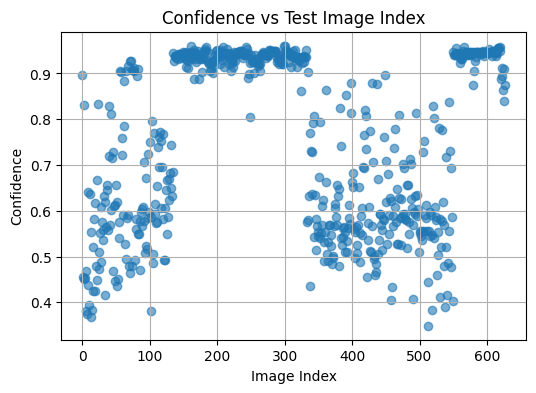

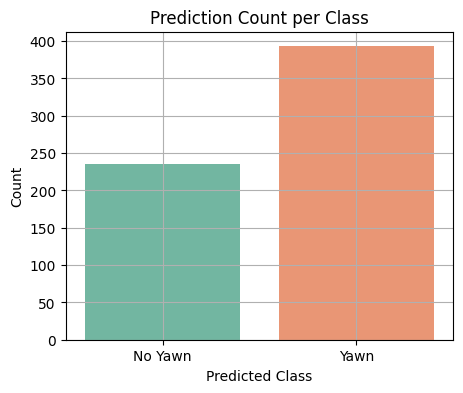

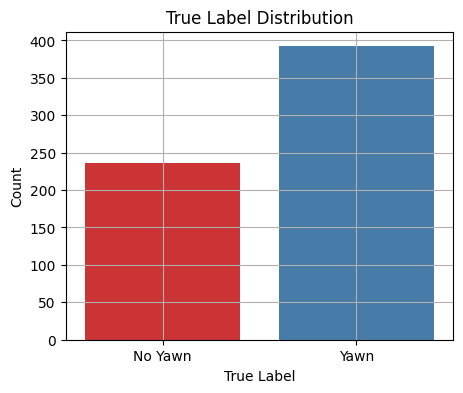

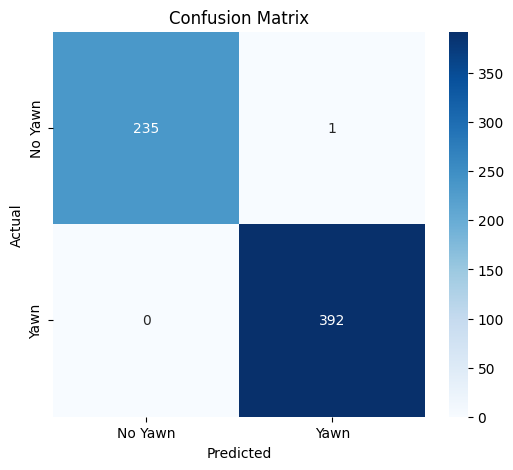

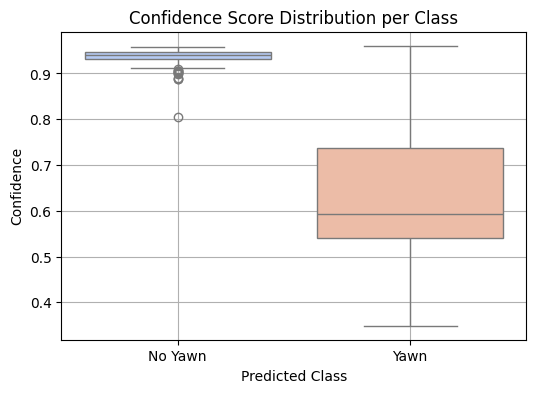

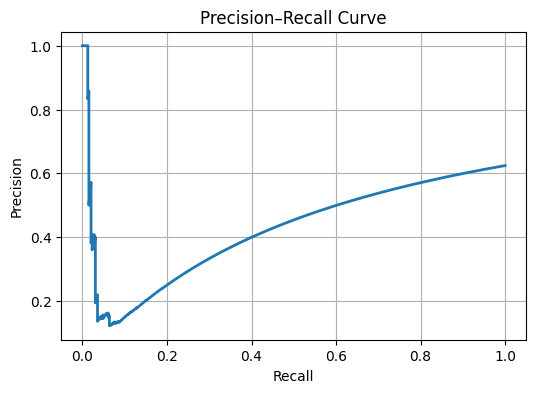

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Load model
model = YOLO("runs/detect/train2/weights/best.pt")

# Paths
test_img_path = "Yawn_detection.v2i.yolov8/test/images"
test_label_path = "Yawn_detection.v2i.yolov8/test/labels"

y_true = []
y_pred = []
conf_scores = []

# Run prediction
results = model.predict(test_img_path, save=False)

for r in results:
    img_name = os.path.basename(r.path)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(test_label_path, label_name)

    # True label
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            cls_true = int(f.read().split()[0])
            y_true.append(cls_true)
    else:
        continue
    
    # Predicted label and confidence
    if len(r.boxes.cls) > 0:
        cls_pred = int(r.boxes.cls[0])
        conf = float(r.boxes.conf[0])
    else:
        cls_pred = -1
        conf = 0.0

    y_pred.append(cls_pred)
    conf_scores.append(conf)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
conf_scores = np.array(conf_scores)


# ✅ 1. Confidence Histogram
plt.figure(figsize=(6,4))
sns.histplot(conf_scores, bins=20, kde=True, color="blue")
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.show()


# ✅ 2. Confidence vs Image Index (Scatter Plot)
plt.figure(figsize=(6,4))
plt.scatter(range(len(conf_scores)), conf_scores, alpha=0.6)
plt.title("Confidence vs Test Image Index")
plt.xlabel("Image Index")
plt.ylabel("Confidence")
plt.grid(True)
plt.show()


# ✅ 3. Prediction Count per Class
plt.figure(figsize=(5,4))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Count per Class")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0,1], ["No Yawn", "Yawn"])
plt.grid(True)
plt.show()


# ✅ 4. True vs Predicted (Bar Plot)
plt.figure(figsize=(5,4))
sns.countplot(x=y_true, palette="Set1")
plt.title("True Label Distribution")
plt.xlabel("True Label")
plt.ylabel("Count")
plt.xticks([0,1], ["No Yawn", "Yawn"])
plt.grid(True)
plt.show()


# ✅ 5. Confusion Matrix Heatmap (Better Style)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Yawn", "Yawn"],
            yticklabels=["No Yawn", "Yawn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ✅ 6. Box Plot of Confidence Scores by Predicted Class
plt.figure(figsize=(6,4))
sns.boxplot(x=y_pred, y=conf_scores, palette="coolwarm")
plt.xticks([0,1], ["No Yawn", "Yawn"])
plt.title("Confidence Score Distribution per Class")
plt.xlabel("Predicted Class")
plt.ylabel("Confidence")
plt.grid(True)
plt.show()


# ✅ 7. Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, conf_scores)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, linewidth=2)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


In [ ]:
from ultralytics import YOLO
import cv2

# Load model
model = YOLO("runs/detect/train2/weights/best.pt")

# ✅ Use IP Webcam stream instead of laptop camera
cap = cv2.VideoCapture("http://10.110.211.109:8080/video")

if not cap.isOpened():
    print("Error: Could not access the IP Webcam stream.")
    raise SystemExit

while True:
    ret, frame = cap.read()
    if not ret:
        print("No frame received! Check IP Webcam app.")
        break

    # Perform prediction
    results = model.predict(frame, conf=0.4)

    # Draw results
    annotated_frame = results[0].plot()

    # Show frame
    cv2.imshow("Yawn Detection - Phone Camera", annotated_frame)

    # Press Q to quit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 16.6ms
Speed: 9.0ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 no_yawn, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 no_yawn, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 1.

In [6]:
matplotlib inline

In [7]:
import onnxruntime as ort
import numpy as np
import cv2

session = ort.InferenceSession("runs/detect/train2/weights/best.onnx",
                               providers=["CPUExecutionProvider"])
in_name = session.get_inputs()[0].name

# dummy input (1,3,640,640)
x = np.zeros((1, 3, 640, 640), dtype=np.float32)
y = session.run(None, {in_name: x})

print("Output count:", len(y))
for i, out in enumerate(y):
    print(f"Output {i} shape:", out.shape)


Output count: 1
Output 0 shape: (1, 6, 8400)


In [ ]:
import cv2
import numpy as np
import onnxruntime as ort

# PHONE CAMERA STREAM (IP Webcam)
url = "http://10.110.211.109:8080/video"
cap = cv2.VideoCapture(url)

# Load ONNX model
onnx_path = "runs/detect/train2/weights/best.onnx"
session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name

def preprocess(frame):
    img = cv2.resize(frame, (640, 640))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = img.transpose(2, 0, 1)
    return np.expand_dims(img, 0)

def postprocess(output, frame):
    output = output.squeeze()        # (6, 8400)
    output = output.T                # --> (8400, 6)

    boxes = output[:, :4]
    scores = output[:, 4]
    classes = output[:, 5]

    h, w, _ = frame.shape

    for i in range(len(scores)):
        if scores[i] < 0.40:  # confidence threshold
            continue

        cx, cy, bw, bh = boxes[i]

        # Convert cx,cy,w,h → x1,y1,x2,y2
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)

        cls_name = "no_yawn" if int(classes[i]) == 0 else "yawn"

        color = (0,255,0) if cls_name == "no_yawn" else (0,165,255)

        cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
        cv2.putText(frame, f"{cls_name} {scores[i]:.2f}", 
                    (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.7, color, 2)

    return frame


while True:
    ret, frame = cap.read()
    if not ret:
        print("Camera disconnected")
        break

    inp = preprocess(frame)
    output = session.run(None, {input_name: inp})[0]

    frame = postprocess(output, frame)

    cv2.imshow("Yawn Detection - ONNX (Phone Camera)", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
%matplotlib inline

In [9]:
from ultralytics import YOLO

# Load your exported ONNX model
model = YOLO("runs/detect/train2/weights/best.pt")

# Run validation to generate metrics and predictions
results = model.val()

print("Model loaded & validation completed.")
print("Classes =", model.names)


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 143.820.1 MB/s, size: 39.3 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 10.9it/s 6.9s0.1s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 1.0ms preprocess, 2.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\221501

In [14]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")
results = model.val()   # <- this generates confusion matrix & metrics


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1275.7261.0 MB/s, size: 43.5 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\valid\labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1197/1197  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 10.7it/s 7.0s0.1s
                   all       1197       1197      0.882      0.878      0.918      0.825
               no_yawn        469        469      0.999          1      0.995      0.963
                  yawn        728        728      0.765      0.755       0.84      0.687
Speed: 1.0ms preprocess, 2.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to C:\Users\Sudharsaa\Documents\221501149\ya

In [18]:
%matplotlib inline


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix from results (shape must be 3×3)
cm = results.confusion_matrix.matrix

# Define labels in correct order
labels = ["no_yawn", "yawn", "background"]

# Convert to percentage
cm_percent = cm / cm.sum() * 100

plt.figure(figsize=(8, 7), facecolor="white")
ax = sns.heatmap(
    cm,
    cmap="Blues",
    square=True,
    linewidths=1.3,
    linecolor="black",
    cbar=True,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix of YOLOv8 on Validation Set", fontsize=18, weight="bold")
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)

# ---------- Perfect Alignment for 3-Class matrix (Value + Percentage) ----------
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = int(cm[i][j])
        percent = cm_percent[i][j]

        # Main value
        ax.text(
            j + 0.5, i + 0.42, f"{value}",
            ha="center", va="center",
            fontsize=15, weight="bold", color="black"
        )
        # Percentage
        ax.text(
            j + 0.5, i + 0.70, f"{percent:.1f}%",
            ha="center", va="center",
            fontsize=13, weight="bold", color="red"
        )

plt.tight_layout()
plt.show()


NameError: name 'results' is not defined

In [32]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")

test_results = model.val(data="Yawn_detection.v2i.yolov8/data.yaml", split="test")


Ultralytics 8.3.226  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 61.017.9 MB/s, size: 43.1 KB)
val: Scanning C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\labels... 628 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 628/628 444.0it/s 1.4s0.3s
val: New cache created: C:\Users\Sudharsaa\Documents\221501149\yawn-detection-yolo\Yawn_detection.v2i.yolov8\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 40/40 7.0it/s 5.7s0.1s
                   all        628        628      0.887      0.875      0.914      0.818
               no_yawn        236        236          1      0.998      0.995      0.963
                  yawn        392        392      0.774      0.751      0.834      0.674
Speed: 1.2ms p